# Predicció de resultats de fútbol (1a divisió espanyola) amb un analisis segons si juguen com a local o visitant i històric

## OBJECTIUS

> MACHINE LEARNING
 1. Models supervisats de regressió i classificació
 2. Utilitzarem vàris models per veure quin treballa millor dels que hem vist durant el curs
 3. Utilitzarem els hiperparametres i avaluarem els resultats
 4. Podem comprovar alguns resultats ja que ja coneixem el resultats d'algunes jornades.
 5. Pels models de regressió haurem de dividir el dataset ja que sino tindriem dos targets (Gols Local i Gols visitant)
 6. Pels models de classifcació en el nostre target serà la columna (1-X-2)
 7. Haurem de fer varis preprocessats aixi com eliminar columnes.

> COMPARACIONS A REALITZAR
 1. PCA o sense PCA
 2. Voldré comparar si val la pena tenir en compte tots els resultats o val més la pena els partits que han jugat directament,     encara que això reduïrà molt el dataset.
 3. Sense el Barça i el Madrid ja que son els més fàcils de predir

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Import preprocessing libraries
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from scipy import stats
from scipy.stats import shapiro
from sklearn.pipeline import Pipeline, make_pipeline

# Import models selection and algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, KFold, cross_validate, cross_val_score, cross_val_predict

In [2]:
# Import two dataset create
df_pfinal = pd.read_csv("resultados_pfinal.csv", sep = ",", encoding="utf-8-sig")

# Show principal dataset
df_pfinal

,Temporada,Jornada,Fecha,Local,Visitante,GolesLocal,GolesVisitante,Quiniela,LP,VP,...,V10r,LV_10cL,LE_10cL,LF_10cL,VV_10cV,VE_10cV,VD_10cV,Periode,L_Handicap,V_Handicap
0,1928-29,1,1929-02-10,Arenas de Guecho,Atlético de Madrid,2,3,2,0,3,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3,4,4
1,1928-29,1,1929-02-10,Espanyol,Real Unión,3,2,1,3,0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3,4,4
2,1928-29,1,1929-02-10,Real Sociedad,Athletic Club,1,1,X,1,1,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3,4,4
3,1928-29,1,1929-02-10,Real Madrid,Europa,5,0,1,3,0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3,4,4
4,1928-29,1,1929-02-12,Racing de Santander,Barcelona,0,2,2,0,3,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26520,2022-23,33,2023-05-03,Valencia,Villarreal,1,1,X,1,1,...,1.3,4.0,2.0,4.0,4.0,1.0,5.0,4,3,3
26521,2022-23,33,2023-05-03,Getafe,Celta de Vigo,1,0,1,3,0,...,1.3,4.0,3.0,3.0,3.0,4.0,3.0,4,3,3
26522,2022-23,33,2023-05-02,Barcelona,Osasuna,1,0,1,3,0,...,1.1,8.0,2.0,0.0,2.0,5.0,3.0,4,1,3
26523,2022-23,33,2023-05-02,Almería,Elche,2,1,1,3,0,...,0.4,4.0,2.0,4.0,1.0,1.0,8.0,4,4,4


In [3]:
# Find which index row i have to cut to complete my dataset
df_pfinal.loc[(df_pfinal["Temporada"] == "1980-81")]

,Temporada,Jornada,Fecha,Local,Visitante,GolesLocal,GolesVisitante,Quiniela,LP,VP,...,V10r,LV_10cL,LE_10cL,LF_10cL,VV_10cV,VE_10cV,VD_10cV,Periode,L_Handicap,V_Handicap
10499,1980-81,1,1980-09-06,Espanyol,Hércules,2,1,1,3,0,...,0.5,5.0,3.0,2.0,1.0,2.0,7.0,1,3,3
10500,1980-81,1,1980-09-06,Sporting de Gijón,Betis,2,0,1,3,0,...,0.8,6.0,3.0,1.0,1.0,5.0,4.0,1,4,3
10501,1980-81,1,1980-09-06,Sevilla,Salamanca,1,0,1,3,0,...,0.8,8.0,1.0,1.0,2.0,2.0,6.0,1,3,4
10502,1980-81,1,1980-09-06,Valencia,Real Sociedad,3,2,1,3,0,...,1.3,6.0,4.0,0.0,2.0,7.0,1.0,1,2,2
10503,1980-81,1,1980-09-07,Almería,Real Madrid,1,2,2,0,3,...,1.6,5.0,5.0,0.0,4.0,4.0,2.0,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10800,1980-81,34,1981-04-26,Sporting de Gijón,Real Sociedad,2,2,X,1,1,...,1.5,8.0,1.0,1.0,4.0,3.0,3.0,3,4,2
10801,1980-81,34,1981-04-26,Murcia,Hércules,2,2,X,1,1,...,0.9,4.0,3.0,3.0,2.0,3.0,5.0,3,3,3
10802,1980-81,34,1981-04-26,Sevilla,Barcelona,1,1,X,1,1,...,0.9,6.0,4.0,0.0,2.0,3.0,5.0,3,3,1
10803,1980-81,34,1981-04-26,Valencia,Las Palmas,3,1,1,3,0,...,1.3,6.0,4.0,0.0,4.0,1.0,5.0,3,2,3


In [4]:
# Drop rows we are not interested
df_pfinal.drop(df_pfinal.index[0:10499], inplace=True)

In [5]:
# Reset index of dataframe
df_pfinal = df_pfinal.reset_index(drop=True)
df_pfinal.head(10)

,Temporada,Jornada,Fecha,Local,Visitante,GolesLocal,GolesVisitante,Quiniela,LP,VP,...,V10r,LV_10cL,LE_10cL,LF_10cL,VV_10cV,VE_10cV,VD_10cV,Periode,L_Handicap,V_Handicap
0,1980-81,1,1980-09-06,Espanyol,Hércules,2,1,1,3,0,...,0.5,5.0,3.0,2.0,1.0,2.0,7.0,1,3,3
1,1980-81,1,1980-09-06,Sporting de Gijón,Betis,2,0,1,3,0,...,0.8,6.0,3.0,1.0,1.0,5.0,4.0,1,4,3
2,1980-81,1,1980-09-06,Sevilla,Salamanca,1,0,1,3,0,...,0.8,8.0,1.0,1.0,2.0,2.0,6.0,1,3,4
3,1980-81,1,1980-09-06,Valencia,Real Sociedad,3,2,1,3,0,...,1.3,6.0,4.0,0.0,2.0,7.0,1.0,1,2,2
4,1980-81,1,1980-09-07,Almería,Real Madrid,1,2,2,0,3,...,1.6,5.0,5.0,0.0,4.0,4.0,2.0,1,4,2
5,1980-81,1,1980-09-07,Athletic Club,Zaragoza,0,1,2,0,3,...,1.0,9.0,1.0,0.0,3.0,1.0,6.0,1,2,3
6,1980-81,1,1980-09-07,Atlético de Madrid,Valladolid,5,2,1,3,0,...,0.4,6.0,2.0,2.0,1.0,1.0,8.0,1,2,3
7,1980-81,1,1980-09-07,Murcia,Barcelona,1,2,2,0,3,...,0.9,4.0,3.0,3.0,1.0,6.0,3.0,1,3,1
8,1980-81,1,1980-09-07,Osasuna,Las Palmas,1,0,1,3,0,...,0.7,7.0,1.0,2.0,2.0,1.0,7.0,1,4,3
9,1980-81,2,1980-09-13,Barcelona,Espanyol,3,1,1,3,0,...,0.6,7.0,2.0,1.0,1.0,3.0,6.0,1,1,3


In [6]:
# Shape of df
df_pfinal.shape

(16026, 25)

In [7]:
# Basic info of df
df_pfinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16026 entries, 0 to 16025
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temporada       16026 non-null  object 
 1   Jornada         16026 non-null  int64  
 2   Fecha           16026 non-null  object 
 3   Local           16026 non-null  object 
 4   Visitante       16026 non-null  object 
 5   GolesLocal      16026 non-null  int64  
 6   GolesVisitante  16026 non-null  int64  
 7   Quiniela        16026 non-null  object 
 8   LP              16026 non-null  int64  
 9   VP              16026 non-null  int64  
 10  L10gf_cL        15896 non-null  float64
 11  V10gf_cV        15896 non-null  float64
 12  L10gc_cL        15896 non-null  float64
 13  V10gc_cV        15896 non-null  float64
 14  L10r            15896 non-null  float64
 15  V10r            15896 non-null  float64
 16  LV_10cL         16026 non-null  float64
 17  LE_10cL         16026 non-null 

## Que fer abans de començar a explorar el dataset

> 0. Observacions inicials
> 1. Descripció de les variables i comprovació del tipus de dada que tenim
> 2. Canvis prinicpals en el dataset -> Noms/Ordre columnes
> 3. Netjar el dataset -> NaNs, Nulls, duplicats

### 0. Observacions inicials

 0. El dataset original hem vist que tenia un total de 26.525 observacions. Tot i això crec que moltes d'aquestes observacions     son de temporades massa anteriors i que no te sentit analitzar ni utilitzar, per això he decidit fer el tall a partir de la     temporada 1980-1981.

 1. La forma del df final (la part que ens interessa) és d'un total de 16.026 observacions i 25 columnes les quals les  
    describirem més endavant.

 2. Podem veure que en aquest dataset tracta dels resultats i estadístiques dels partits de futbol de la primera divisió     
    espanyola desde la temporada 1980-1981.

 3. Amb aquesta reducció veiem que han desaparegut alguns NANS que es mostraven en el dataset original per falta de dades 
    anteriors segurament al crear les columnes jo mateix.

 4. Amb l'exploració de la funció .info veiem que hi ha més columnes amb valors Nulls. Haurem d'estudiarlos tot i que ja ens  
    donem compte que no hi ha molts. Menys de 300. La meva teoria (al haver creat jo les columnes) és que son equips que no han     disputat suficients partits a primera divisió i per tant els hi falta dades.

#### 1. Descripció de les variables i comprovació del tipus de dada que tenim

0. **Temporada**: Descriu quina temporada estem (obj)
1. **Jornada**: Número de la jornada en que es va jugar el partit. És un index que es va repetint. (int o obj)
2. **Fecha**: Mostra el dia en que es va jugar el partit. És una data (datetime or obj)
3. **Local**: Mostra el nom de l'equip local d'aquell partit (obj)
4. **Visitante**: Mostra el nom de l'equip visitant d'aquell partit (obj)
5. **GolesLocal**: Mostra el número de gols de l'equip local en aquell partit (int64)
6. **GolesVisitante**: Mostra el número de gols de l'equip visitant en aquell partit (int64)
7. **Quiniela**: Mostra el resultat d'aquell partit (1= Ha guanyat l'equip Local, X= Han empatat, 2= Ha guanyat l'equip visitant) (obj)
8. **LP**: Punts de l'equip local aconseguits en aquell partit (3=Victoria, 1=Empat, 0=Derrota). (int64)
9. **VP**: Punts de l'equip visitant aconseguits en aquell partit (3=Victoria, 1=Empat, 0=Derrota). (int64)
10. **L10gf_cL**: Mitjà de gols a favor de l'equip local en els últims 10 partits com a local abans d'aquest partit (float64)
11. **V10gf_cV**: Mitjà de gols a favor de l'equip visitant en els últims 10 partits com a visitant abans d'aquest partit (float64)
12. **L10gc_cL**: Mitjà de gols en contra de l'equip local en els últims 10 partits com a local abans d'aquest partit (float64)
13. **V10gc_cV**: Mitjà de gols en contra de l'equip visitant en els últims 10 partits com a visitant abans d'aquest partit (float64)
14. **L10r**: Mitjà de punts de l'equip local en els últims 10 partits com a local abans d'aquest partit (float64)
15. **V10r**: Mitjà de punts de l'equip visitant en els últims 10 partits com a visitant abans d'aquest partit (float64)
16. **LV_10cL: Número de victòries de l'equip local ens els últims 10 partits com a local abans d'aquest partit (int)
17. **LE_10cL**: Número d'empats de l'equip local ens els últims 10 partits com a local abans d'aquest partit (int)
18. **LF_10cL**: Número de derrotes de l'equip local ens els últims 10 partits com a local abans d'aquest partit (int)
19. **VV_10cV**: Número de victòries de l'equip visitant ens els últims 10 partits com a visitant abans d'aquest partit (int)
20. **VE_10cV**: Número d'empats de l'equip visitant ens els últims 10 partits com a visitant abans d'aquest partit (int)
21. **VD_10cV**: Número de derrotes de l'equip visitant ens els últims 10 partits com a visitant abans d'aquest partit (int)
22. **Periode**: Divisió en 4 períodes segons el moment de la temporada (1=01/08 a 31/10, 2=01/11 al 31/01, 3=01/02 al 31/04 i 4='1/05 al 31/07 (int o obj)
23. **L_Handicap**: Valor que se li dona a l'equip local segons la posició mitjana de les darreres 10 temporades (1= Pos <=3, 2= 3< Pos<=7, 3= 7<Pos<14, 4= la resta) (int)
24. **V_Handicap**: Valor que se li dona a l'equip visitant segons la posició mitjana de les darreres 10 temporades (1= Pos <=3, 2= 3< Pos<=7, 3= 7<Pos<14, 4= la resta) (int)

In [8]:
# Change dtypes of columns that are int and we have it as float.
df_pfinal[["LV_10cL", "LE_10cL", "LF_10cL", "VV_10cV", "VE_10cV", "VD_10cV"]] = df_pfinal[["LV_10cL", "LE_10cL", "LF_10cL", "VV_10cV", "VE_10cV", "VD_10cV"]].astype(int)

# Check it
df_pfinal.dtypes

Temporada          object
Jornada             int64
Fecha              object
Local              object
Visitante          object
GolesLocal          int64
GolesVisitante      int64
Quiniela           object
LP                  int64
VP                  int64
L10gf_cL          float64
V10gf_cV          float64
L10gc_cL          float64
V10gc_cV          float64
L10r              float64
V10r              float64
LV_10cL             int32
LE_10cL             int32
LF_10cL             int32
VV_10cV             int32
VE_10cV             int32
VD_10cV             int32
Periode             int64
L_Handicap          int64
V_Handicap          int64
dtype: object

In [9]:
# Know how many unique values are in each column
df_pfinal.nunique()

Temporada           43
Jornada             44
Fecha             3941
Local               51
Visitante           51
GolesLocal          11
GolesVisitante       9
Quiniela             3
LP                   3
VP                   3
L10gf_cL            45
V10gf_cV            38
L10gc_cL            31
V10gc_cV            44
L10r                28
V10r                30
LV_10cL             11
LE_10cL             10
LF_10cL             10
VV_10cV             11
VE_10cV              9
VD_10cV             11
Periode              4
L_Handicap           4
V_Handicap           4
dtype: int64

**Podem extreure la següent informació:**

1. Hi ha 43 temporades.
2. El número màxim de jornades que hi hagut en una temporada és 44.
3. Hi han participat 51 equips diferents
4. El número màxim de gols com a local que ha fet un equip han estat 10 (11-1 perquè pot ser valor 0) i com a visitant 8.
5. Els locals tant en els empats i derrotes mai s'han arribat a les 10 consecutives (suposo que és el més elevat). I els visitants passa amb els empats però en dos ocasions, suposo que ni 9 ni 10 en els darrers 10 partits.
6. També hem vist que una de les opcions de target ("Quiniela") es una variable objecte perquè un dels valors és una X i per tant no pot ser númerica. Crec que una bona solució és convertir la X en 0 i passar-la a númerica.

In [10]:
# Replace values of Quiniela columns to be an int and not an object
df_pfinal["Quiniela"] = df_pfinal["Quiniela"].replace({"1" : 1, "X" : 3, "2" : 2})
df_pfinal.dtypes

Temporada          object
Jornada             int64
Fecha              object
Local              object
Visitante          object
GolesLocal          int64
GolesVisitante      int64
Quiniela            int64
LP                  int64
VP                  int64
L10gf_cL          float64
V10gf_cV          float64
L10gc_cL          float64
V10gc_cV          float64
L10r              float64
V10r              float64
LV_10cL             int32
LE_10cL             int32
LF_10cL             int32
VV_10cV             int32
VE_10cV             int32
VD_10cV             int32
Periode             int64
L_Handicap          int64
V_Handicap          int64
dtype: object

#### 2. Canvis prinicpals en el dataset -> Noms/Ordre columnes

In [11]:
# Change the column names to make it shorter
df_pfinal.columns = ["Temp", "Jor", "Data", "Loc", "Vis", "LG", "VG", "1-X-2", "LP", "VP", "L10gf_cL", "V10gf_cV", "L10gc_cL", "V10gc_cV", "L10r", "V10r", "LV_10cL", "LE_10cL", "LD_10cL", "VV_10cV", "VE_10cV", "VD_10cV", "Per", "L_Han", "V_Han"]

# Check it
df_pfinal.head(5)

,Temp,Jor,Data,Loc,Vis,LG,VG,1-X-2,LP,VP,...,V10r,LV_10cL,LE_10cL,LD_10cL,VV_10cV,VE_10cV,VD_10cV,Per,L_Han,V_Han
0,1980-81,1,1980-09-06,Espanyol,Hércules,2,1,1,3,0,...,0.5,5,3,2,1,2,7,1,3,3
1,1980-81,1,1980-09-06,Sporting de Gijón,Betis,2,0,1,3,0,...,0.8,6,3,1,1,5,4,1,4,3
2,1980-81,1,1980-09-06,Sevilla,Salamanca,1,0,1,3,0,...,0.8,8,1,1,2,2,6,1,3,4
3,1980-81,1,1980-09-06,Valencia,Real Sociedad,3,2,1,3,0,...,1.3,6,4,0,2,7,1,1,2,2
4,1980-81,1,1980-09-07,Almería,Real Madrid,1,2,2,0,3,...,1.6,5,5,0,4,4,2,1,4,2


In [12]:
# Reorder the columns to more logic order
df_pfinal = df_pfinal[["Temp", "Jor", "Data", "Per", "Loc", "Vis", "LG", "VG", "1-X-2", "LP", "VP", "L_Han","L10r", "L10gf_cL", "L10gc_cL",  "LV_10cL", "LE_10cL", "LD_10cL", "V_Han", "V10r",  "V10gf_cV",  "V10gc_cV", "VV_10cV", "VE_10cV", "VD_10cV"]]

# Check it
df_pfinal.head(5)

,Temp,Jor,Data,Per,Loc,Vis,LG,VG,1-X-2,LP,...,LV_10cL,LE_10cL,LD_10cL,V_Han,V10r,V10gf_cV,V10gc_cV,VV_10cV,VE_10cV,VD_10cV
0,1980-81,1,1980-09-06,1,Espanyol,Hércules,2,1,1,3,...,5,3,2,3,0.5,0.8,1.5,1,2,7
1,1980-81,1,1980-09-06,1,Sporting de Gijón,Betis,2,0,1,3,...,6,3,1,3,0.8,0.9,1.4,1,5,4
2,1980-81,1,1980-09-06,1,Sevilla,Salamanca,1,0,1,3,...,8,1,1,4,0.8,0.3,1.1,2,2,6
3,1980-81,1,1980-09-06,1,Valencia,Real Sociedad,3,2,1,3,...,6,4,0,2,1.3,1.1,0.8,2,7,1
4,1980-81,1,1980-09-07,1,Almería,Real Madrid,1,2,2,0,...,5,5,0,2,1.6,1.0,1.0,4,4,2


#### 3. Netejar el dataset -> NaNs, Nulls, duplicats

In [13]:
# Show nulls, NaNs and duplicates
print("\033[1mNans:\n\033[0m", df_pfinal.isna().sum(), "\033[1m\n\nNulls:\n\033[0m", df_pfinal.isnull().sum(), "\033[1m\n\nDuplicats:\n\033[0m", df_pfinal.duplicated().sum())

Nans:
 Temp          0
Jor           0
Data          0
Per           0
Loc           0
Vis           0
LG            0
VG            0
1-X-2         0
LP            0
VP            0
L_Han         0
L10r        130
L10gf_cL    130
L10gc_cL    130
LV_10cL       0
LE_10cL       0
LD_10cL       0
V_Han         0
V10r        130
V10gf_cV    130
V10gc_cV    130
VV_10cV       0
VE_10cV       0
VD_10cV       0
dtype: int64 

Nulls:
 Temp          0
Jor           0
Data          0
Per           0
Loc           0
Vis           0
LG            0
VG            0
1-X-2         0
LP            0
VP            0
L_Han         0
L10r        130
L10gf_cL    130
L10gc_cL    130
LV_10cL       0
LE_10cL       0
LD_10cL       0
V_Han         0
V10r        130
V10gf_cV    130
V10gc_cV    130
VV_10cV       0
VE_10cV       0
VD_10cV       0
dtype: int64 

Duplicats:
 0


_Observem que es repeteixen els NaNs i Nulls en les mateixes columnes. Segurament es repetiren en files alternes ja que tal i com sospitem, es deu a faltes de dades dels equips amb poca participació a la primera divisió espanyola. Per tant segons si juguen com a locals o visitants es van alternant les Nans. 130 files de 16.026 son un 0,81% aprox de les dades. Podriem eliminarles pero vull mirar si podem arreglar-ho per no perdre dades. Per altra banda, no tenim files duplicades._

In [14]:
# check Nans rows and create a variable to work with it
df_pfinal[df_pfinal.isna().any(axis=1)]

,Temp,Jor,Data,Per,Loc,Vis,LG,VG,1-X-2,LP,...,LV_10cL,LE_10cL,LD_10cL,V_Han,V10r,V10gf_cV,V10gc_cV,VV_10cV,VE_10cV,VD_10cV
2235,1987-88,1,1987-08-29,1,Valencia,Logroñés,2,0,1,3,...,2,3,5,4,NaN,NaN,NaN,0,0,0
2245,1987-88,2,1987-09-06,1,Logroñés,Athletic Club,1,1,3,1,...,0,0,0,2,0.6,0.5,1.3,1,3,6
2258,1987-88,3,1987-09-13,1,Atlético de Madrid,Logroñés,3,0,1,3,...,7,0,3,4,NaN,NaN,NaN,0,0,1
2262,1987-88,4,1987-09-19,1,Logroñés,Sabadell,1,1,3,1,...,0,1,0,3,0.7,0.5,1.3,1,4,5
2277,1987-88,5,1987-09-27,1,Mallorca,Logroñés,4,0,1,3,...,4,3,3,4,NaN,NaN,NaN,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14330,2018-19,16,2018-12-16,2,Huesca,Villarreal,2,2,3,1,...,0,3,4,2,1.2,1.5,1.8,3,3,4
14343,2018-19,17,2018-12-23,2,Valencia,Huesca,2,1,1,3,...,2,7,1,4,NaN,NaN,NaN,1,1,6
14353,2018-19,18,2019-01-05,2,Huesca,Betis,2,1,1,3,...,0,4,4,3,1.1,1.1,1.4,3,2,5
14365,2018-19,19,2019-01-12,2,Leganés,Huesca,1,0,1,3,...,4,4,2,4,NaN,NaN,NaN,1,1,7


_Anem a indagar més per veure quins son els equips que contenen NaNs_

In [15]:
# Show the teams that are generating NaNs
print("Hi ha un total de", df_pfinal.loc[df_pfinal["L10r"].isna()]["Loc"].nunique(), "equips locals que generan NaNs i aquests són: \n", df_pfinal.loc[df_pfinal["L10r"].isna()]["Loc"].unique())
print("\n\n Hi ha un total de", df_pfinal.loc[df_pfinal["V10r"].isna()]["Vis"].nunique(), "equips visitants que generan NaNs i aquests són: \n", df_pfinal.loc[df_pfinal["V10r"].isna()]["Vis"].unique())

Hi ha un total de 13 equips locals que generan NaNs i aquests són: 
 ['Logroñés' 'Albacete' 'Compostela' 'Mérida' 'Extremadura' 'Villarreal'
 'Numancia' 'Getafe' 'Xerez' 'Eibar' 'Leganés' 'Girona' 'Huesca']


 Hi ha un total de 13 equips visitants que generan NaNs i aquests són: 
 ['Logroñés' 'Albacete' 'Compostela' 'Mérida' 'Extremadura' 'Villarreal'
 'Numancia' 'Getafe' 'Xerez' 'Eibar' 'Leganés' 'Girona' 'Huesca']


Veiem que "només" son 13 equips que generan NaNs, curiosament 130 x 10 = 130 (el mateix número de NaNs que tenim) i 10 és el valor utilitzat alhora de crear les columnes de refèrencia.

Per tant la conclusió d'aquests NaNs és que es tracta dels primers 10 partits d'aquests equips que participen a la primera divisió. Possibles actuacions:  
    a) Que enlloc de que la mitja sigui de 10 partits, fins que no hi arribin calcular la mitja dels partits anteriors i la
       primera marcar-la com a 0.   
    b) Convertir els NaNs en 0.   
    c) **Eliminar les files.**
    
L'opció B la descarto perquè crec que afectaria al model alhora d'entrenar-lo si posem aquestes estadístiques a 0. Ja que partirien en desvantatge amb altres equips acabats d'ascendir però que si havien participat abans de la temporada que hem marcat de tall 1980-1981. 

L'opció A, tot i que em sembla millor que l'opció B també em penso que afectaria a l'entrenament d'aquests equips en el model.

Per tant, tenint en compte que segurament son només 10 resultats per equip i que el total de Nulls equivalen a un 0,81% de les dades les eliminem.

In [16]:
# Drop NaNs
df_pfinal = df_pfinal.dropna()

# Check if there still NaNs or Nulls
print("\033[1mNans:\n\033[0m", df_pfinal.isna().sum(), "\033[1m\n\nNulls:\n\033[0m", df_pfinal.isnull().sum())

Nans:
 Temp        0
Jor         0
Data        0
Per         0
Loc         0
Vis         0
LG          0
VG          0
1-X-2       0
LP          0
VP          0
L_Han       0
L10r        0
L10gf_cL    0
L10gc_cL    0
LV_10cL     0
LE_10cL     0
LD_10cL     0
V_Han       0
V10r        0
V10gf_cV    0
V10gc_cV    0
VV_10cV     0
VE_10cV     0
VD_10cV     0
dtype: int64 

Nulls:
 Temp        0
Jor         0
Data        0
Per         0
Loc         0
Vis         0
LG          0
VG          0
1-X-2       0
LP          0
VP          0
L_Han       0
L10r        0
L10gf_cL    0
L10gc_cL    0
LV_10cL     0
LE_10cL     0
LD_10cL     0
V_Han       0
V10r        0
V10gf_cV    0
V10gc_cV    0
VV_10cV     0
VE_10cV     0
VD_10cV     0
dtype: int64


_Ja no tenim ni NaNs ni Nulls, per fi podem començar amb l'exploració del dataset_

## Exploració del dataset

> 1. Resum estadístic de les variables
> 2. Correlació entre variables
> 3. Interecció i visualització de diferents gràfiques interessants (algunes perquè podriem fer un analisi molt exhaustiu)
> 4. Conclusions i Objectius

#### 1. Resum estadístic de les variables

In [17]:
# Check final shape of df
df_pfinal.shape

(15766, 25)

In [18]:
# Check statiscal summary of numeric variables
df_pfinal.describe().T

,count,mean,std,min,25%,50%,75%,max
Jor,15766.0,19.555245,10.981267,1.0,10.0,20.0,29.0,44.0
Per,15766.0,2.327731,0.957770,1.0,2.0,2.0,3.0,4.0
LG,15766.0,1.555563,1.303848,0.0,1.0,1.0,2.0,10.0
VG,15766.0,1.047634,1.084072,0.0,0.0,1.0,2.0,8.0
1-X-2,15766.0,1.768679,0.835745,1.0,1.0,2.0,3.0,3.0
LP,15766.0,1.735190,1.293900,0.0,1.0,1.0,3.0,3.0
VP,15766.0,1.004503,1.218180,0.0,0.0,1.0,1.0,3.0
L_Han,15766.0,2.915007,0.877246,1.0,3.0,3.0,3.0,4.0
L10r,15766.0,1.741634,0.522327,0.1,1.4,1.7,2.1,3.0
L10gf_cL,15766.0,1.560599,0.586688,0.3,1.2,1.5,1.9,4.8


In [19]:
# Check description of categoric variables
df_pfinal.describe(include="O").T

,count,unique,top,freq
Temp,15766,43,1996-97,442
Data,15766,3924,1996-03-27,10
Loc,15766,51,Barcelona,804
Vis,15766,51,Real Madrid,803


**Conclusions resum estadístic**

Veiem que el df s'ha quedat amb 25 columnes i 15766 observacions. 

<u>_Variables númeriques_</u>

Hem de tenir en compte que algunes variables no te gaire sentit fer un analisi estadístic ja que no aporten valor tot i ser númeriques. Per exemple la variable _Jor_ ve a ser un index, i _Per_ no deixa de ser una classificació de les dates per tant tampoc aporta molta informació. La resta de variables les podem analitzar per grups de local i visitant:

1. **L_Han i V_Han**: Veiem que son molt semblants i te lògica perquè al final te a veure amb els equips i la posició de lliga que van quedar, per tant no te res a veure si juguen con a locals i visitants. Podem observar que predomina el Handicap 3. Que son els equips, que ni queden en les últimes places ni en les primeres. Que no acaban jugant Europa. 

2. **LG i VG**: Gols que defineixen el resultat del partit. En els gols dels equips locals si que veiem diferencia entre la mitjà i la mitjana. També veiem que es marquen una mica més de gols com a local però ambdos casos el rang en la seva majoria va del 0 al 2. Trobarem outliers perque veiem un gran salt entre el 3r Quartil i el 4t en ambudes variables.

3. **1-X-2**: Aquesta variable és un dels targets si optem per fer un model supervisat classificació. Sembla que predomina el valor 1, cosa que significa que predomina les victories locals (algo lògic a priori). 

4. **LP i VP**:  D'aqui amb els quartils podem extreure la informació que els punts locals predomina el 3 i l'1. Cosa que significa que els locals rarament perden i per altra banda els visitants els hi costa guanya. Sembla més probable que ens trobem outliers en el cas de LP ja que al diferencia entre la mitja i la mitjana és superior.

5. **L10r i V10r**: Pel que fa a la mitja de punts dels últims 10 partits veiem comportaments similars a les variables anteriors. Apostaria que tenen una correlació entre elles. On veiem més diferencia entre quartils son entre 0 i el 1r i el 3r i 4t.

6. **L10gf, V10gf i L10gc i V10gv**: Aqui també semblen correlacionades inversament i te tota la lògica del món que hi hagi relació entre Gf del local i Gc del visitant i viceversa. Veiem que els valors s'assemblen molt, quasi calcats. Per la diferència entre quartils també apostaria per outliers.

7. **LV_10cL, LE_10cL, LD_10cL i VV_10cL, VE_10cL, VD_10cL**: Aquí, com era d'esperar també veiem correlacions inverses entre les victories i derrotes de locals i visitants i viceversa. El creixement entre quartils no es proporcional, per tant és possible que hi hagi outliers.

En general veiem moltes correlacions inverses entre Locals i Visitants. També ens hem trobat variables que no ens interessa gaire el seu analisi estadistic, ja que tenen una intenció més de index o classificació. Aquest analisi també podem observar el rang que tenen les variables (min i max). Seguim aprofundint amb l'analisi del dataset amb una matriu de correlació.

<u>_Variables NO númeriques_</u>

De lels variables númeriques ens aporten poca informació més enllà el número de temporades o d'equips que ja l'hem comentat abans. També ens aporta quina és la temporada amb més partits, que possiblement també serà amb més equips així com tant Barcelona i Real Madrid son els equips que apareixen més vegades. 

#### 2. Correlació entre variables

Text(0.5, 1.0, 'Correlation Heatmap')

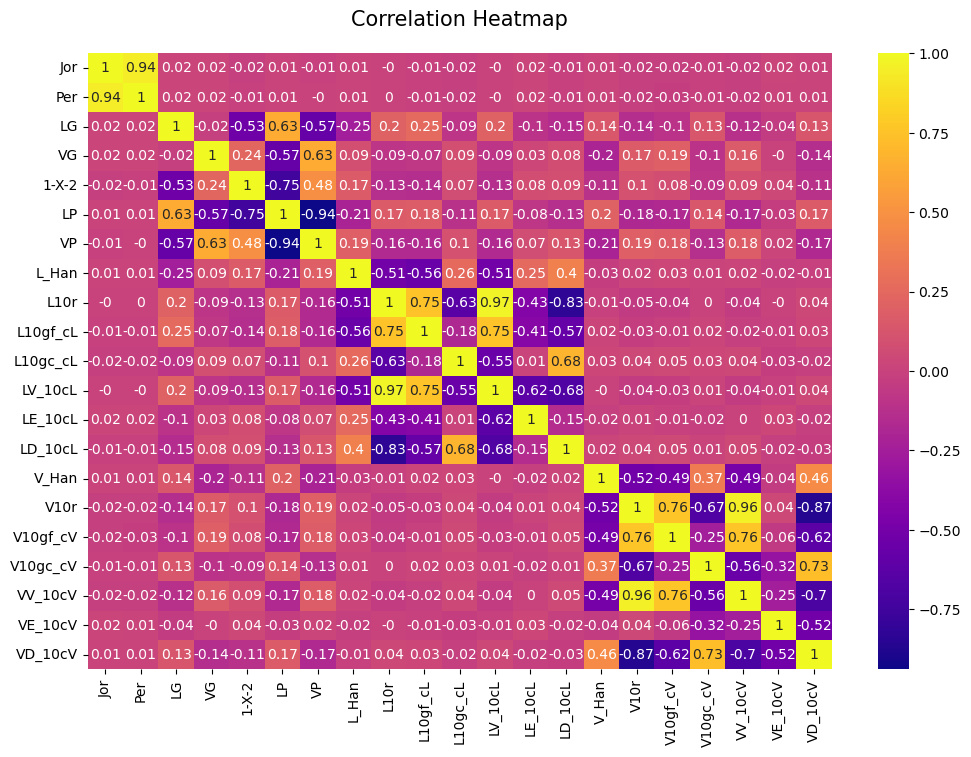

In [20]:
# Correlation heatmap plot
# plot size
plt.figure(figsize=(12,8))
sns.heatmap(df_pfinal.corr().round(2), annot=True, cmap="plasma")
plt.title('Correlation Heatmap', fontsize=15, pad=20)

**Conclusions correlació**

Tal com hem dit abans les variables _Jor i Per_ només tenen relació entre elles, com deien son més un index per relacionar el dia del partit i la jornada. Te lògica que estiguin relacionades. 

Amb la matriu de correlació podem veure com les variables locals es relacionen molt entre elles i les visitants entre elles també. Podem veure blocs clarament diferenciats.

Jo m'esperava més relació entre les variables Locals i Visitants pero inversament proporcionals tal com semblava que passava amb l'analisi estadístic al obtenir dades molt semblants. En canvi si que era d'esperar correlació inversa entre victories i derrotes.

Una columna que jo li donc valor és el Handicap i m'interessava veure especialment com es relacionaven. En el cas de Locals veiem que la relació és lleugerament superior a la dels visitants. On supera el 0.5 en la mija de punts, gols a favor i victories però les dades negatives tenen relació però més baixa. En el cas del handicap com a visitant esta correlacionat d'una manera similar però no tant. 

#### 3. Interecció i visualització de diferents gràfiques interessants (algunes perquè podriem fer un analisi molt exhaustiu)
 1. Veure número d'equips i jornades per temporada 
 2. Ranking dels equips per Handicap
 3. Relació entre Handicap i més partits jugats a primera divisió
 4. Distribució percentual dels partits en cada periode
 5. Relació periodes amb punts i handicaps

In [21]:
# 1. Veure número d'equips i jornades per temporada. 
# Find how many match rounds are in season 1980-1981 and which teams played below
print("\033[1m1. Veure número d'equips i jornades per temporada\n\n\033[0m")
for jornada in df_pfinal.Temp.unique():
    print(f"La Temporada {jornada} te", df_pfinal.loc[(df_pfinal['Temp'] == f"{jornada}")]["Jor"].nunique(), 
          "jornades i el total d'equips que hi han participat son", 
          df_pfinal.loc[(df_pfinal['Temp'] == f"{jornada}")]["Loc"].nunique(), "\n")


1. Veure número d'equips i jornades per temporada


La Temporada 1980-81 te 34 jornades i el total d'equips que hi han participat son 18 

La Temporada 1981-82 te 34 jornades i el total d'equips que hi han participat son 18 

La Temporada 1982-83 te 34 jornades i el total d'equips que hi han participat son 18 

La Temporada 1983-84 te 34 jornades i el total d'equips que hi han participat son 18 

La Temporada 1984-85 te 34 jornades i el total d'equips que hi han participat son 18 

La Temporada 1985-86 te 34 jornades i el total d'equips que hi han participat son 18 

La Temporada 1986-87 te 44 jornades i el total d'equips que hi han participat son 18 

La Temporada 1987-88 te 38 jornades i el total d'equips que hi han participat son 20 

La Temporada 1988-89 te 38 jornades i el total d'equips que hi han participat son 20 

La Temporada 1989-90 te 38 jornades i el total d'equips que hi han participat son 20 

La Temporada 1990-91 te 38 jornades i el total d'equips que hi han participat 

In [22]:
# 2. Ranking dels equips per Handicap
# Show rows and columns by defalut and not all anymore
pd.reset_option("display.max_columns")

# Show rank of Handicap of each team at all df
df_pfinal.groupby(["L_Han", "Loc"]).count().sort_values(by=["L_Han", "Jor"], ascending=[True, False])

Temp  Jor  Data  Per  Vis   LG   VG  1-X-2   LP  \
L_Han Loc                                                                       
1     Real Madrid              768  768   768  768  768  768  768    768  768   
      Barcelona                749  749   749  749  749  749  749    749  749   
      Atlético de Madrid        36   36    36   36   36   36   36     36   36   
2     Atlético de Madrid       520  520   520  520  520  520  520    520  520   
      Valencia                 506  506   506  506  506  506  506    506  506   
...                            ...  ...   ...  ...  ...  ...  ...    ...  ...   
4     Gimnàstic de Tarragona    19   19    19   19   19   19   19     19   19   
      Hércules                  19   19    19   19   19   19   19     19   19   
      Lleida                    19   19    19   19   19   19   19     19   19   
      Córdoba                   18   18    18   18   18   18   18     18   18   
      Xerez                      9    9     9    9    9    9    9      9    9   

                               VP  ...  LV_10cL  LE_10cL  LD_10cL  V_Han  \
L_Han Loc                          ...                                     
1     Real Madrid             768  ...      768      768      768    768   
      Barcelona               749  ...      749      749      749    749   
      Atlético de Madrid       36  ...       36       36       36     36   
2     Atlético de Madrid      520  ...      520      520      520    520   
      Valencia                506  ...      506      506      506    506   
...                           ...  ...      ...      ...      ...    ...   
4     Gimnàstic de Tarragona   19  ...       19       19       19     19   
      Hércules                 19  ...       19       19       19     19   
      Lleida                   19  ...       19       19       19     19   
      Córdoba                  18  ...       18       18       18     18   
      Xerez                     9  ...        9        9        9      9   

                              V10r  V10gf_cV  V10gc_cV  VV_10cV  VE_10cV  \
L_Han Loc                                                                  
1     Real Madrid              768       768       768      768      768   
      Barcelona                749       749       749      749      749   
      Atlético de Madrid        36        36        36       36       36   
2     Atlético de Madrid       520       520       520      520      520   
      Valencia                 506       506       506      506      506   
...                            ...       ...       ...      ...      ...   
4     Gimnàstic de Tarragona    19        19        19       19       19   
      Hércules                  19        19        19       19       19   
      Lleida                    19        19        19       19       19   
      Córdoba                   18        18        18       18       18   
      Xerez                      9         9         9        9        9   

                              VD_10cV  
L_Han Loc                              
1     Real Madrid                 768  
      Barcelona                   749  
      Atlético de Madrid           36  
2     Atlético de Madrid          520  
      Valencia                    506  
...                               ...  
4     Gimnàstic de Tarragona       19  
      Hércules                     19  
      Lleida                       19  
      Córdoba                      18  
      Xerez                         9  

[84 rows x 23 columns]

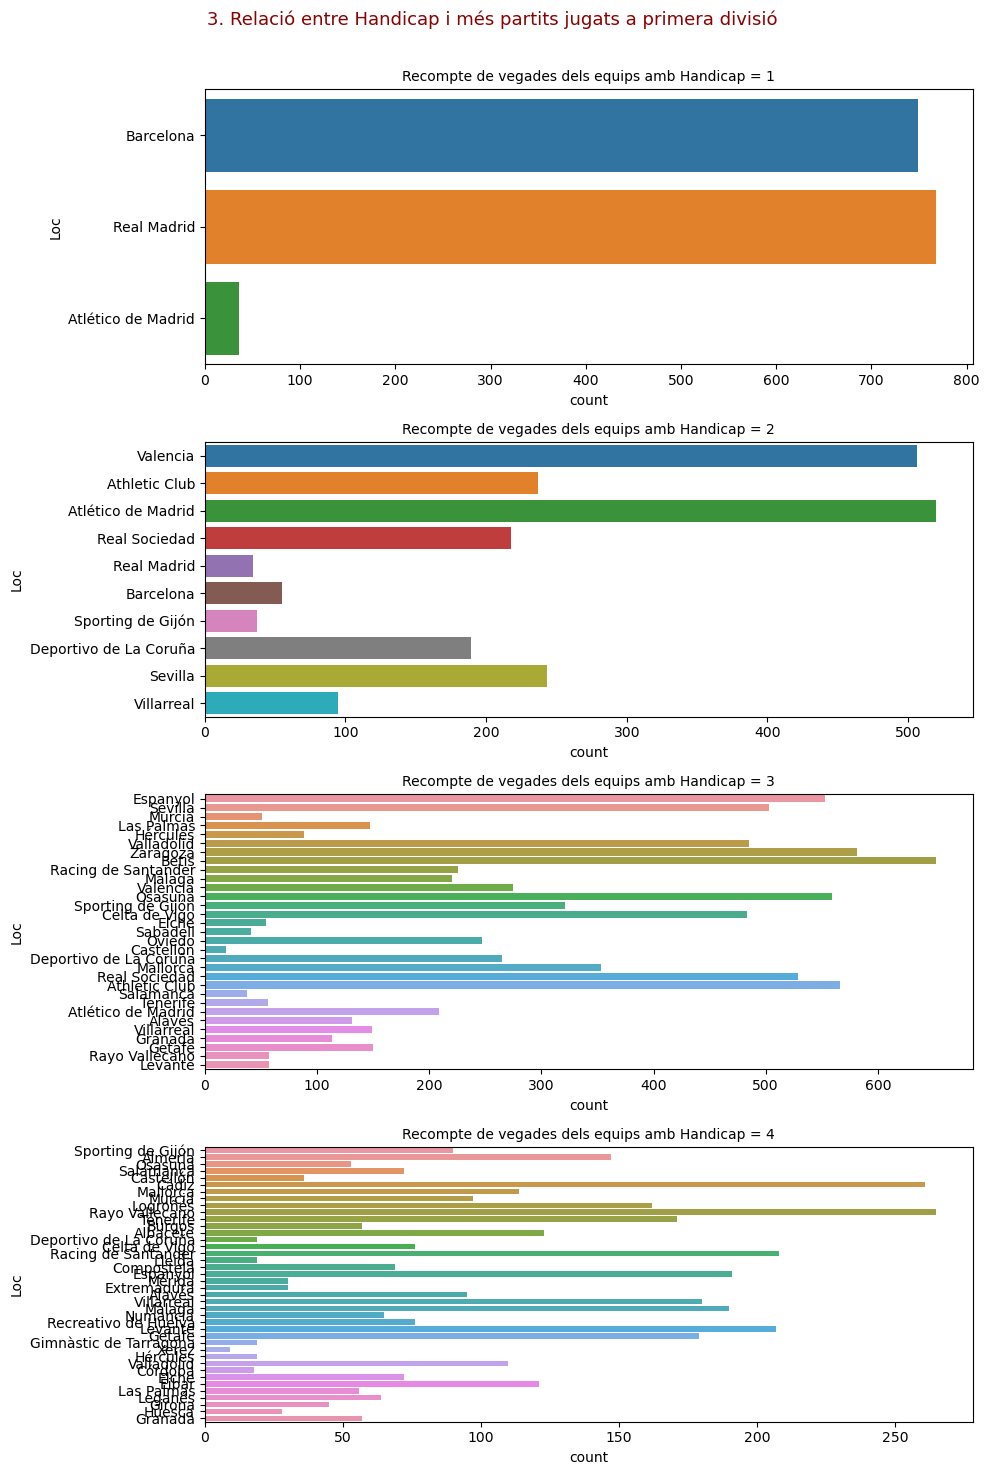

In [23]:
# 3. Relació entre Handicap i més partits jugats a primera divisió
# Create plots to show distribution of teams by handicap and appearances
fig, axs = plt.subplots(nrows=4, figsize=(10,15))

sns.countplot(y="Loc", data=df_pfinal.loc[df_pfinal["L_Han"] == 1], ax=axs[0])
axs[0].set_title("Recompte de vegades dels equips amb Handicap = 1", fontsize= 10)

                                          
sns.countplot(y="Loc", data=df_pfinal.loc[df_pfinal["L_Han"] == 2], ax=axs[1])
axs[1].set_title("Recompte de vegades dels equips amb Handicap = 2", fontsize= 10)
                                          

sns.countplot(y="Loc", data=df_pfinal.loc[df_pfinal["L_Han"] == 3], ax=axs[2])
axs[2].set_title("Recompte de vegades dels equips amb Handicap = 3", fontsize= 10)
                                          

sns.countplot(y="Loc", data=df_pfinal.loc[df_pfinal["L_Han"] == 4], ax=axs[3])
axs[3].set_title("Recompte de vegades dels equips amb Handicap = 4", fontsize= 10)

plt.suptitle("3. Relació entre Handicap i més partits jugats a primera divisió \n\n", fontsize= 13, color = "Darkred")

plt.tight_layout()
plt.show()

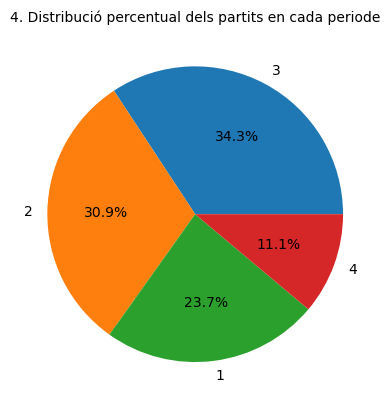

In [24]:
#4. Distribució percentual dels partits en cada periode
# Pie plot with % of matches in each period of all df
figsize=(6, 3)
plt.pie(df_pfinal["Per"].value_counts(), labels=df_pfinal["Per"].value_counts().index, autopct="%1.1f%%")
plt.title("4. Distribució percentual dels partits en cada periode", fontsize = 10)

plt.show()

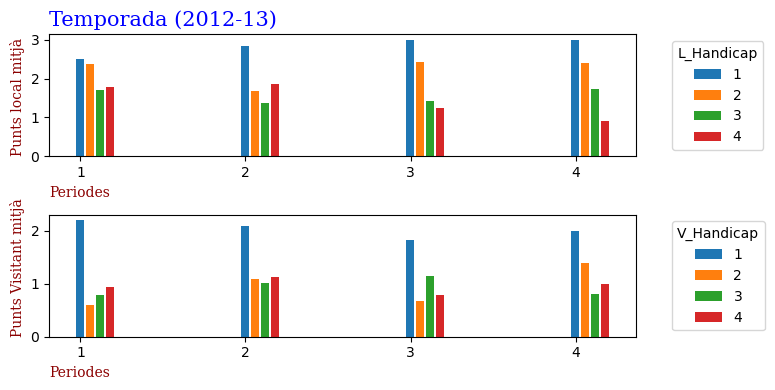

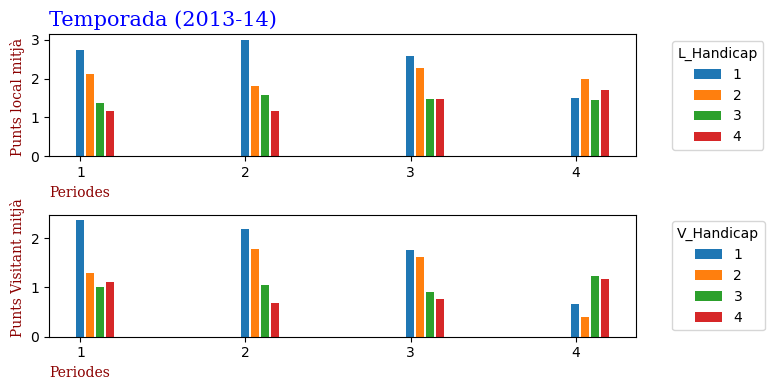

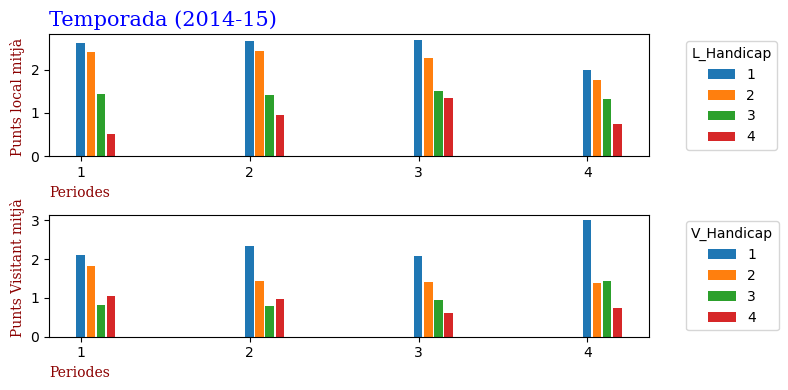

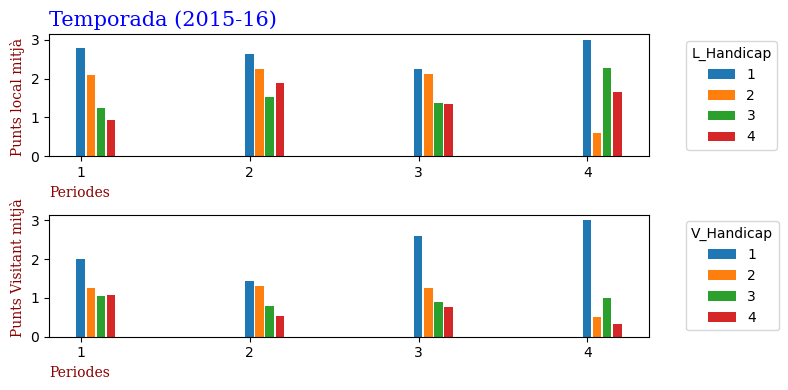

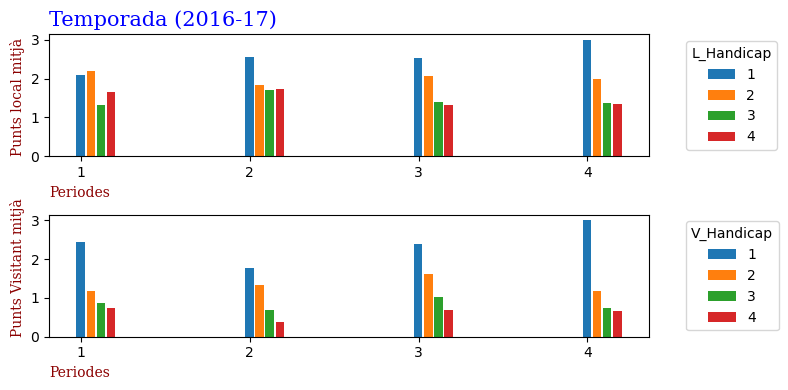

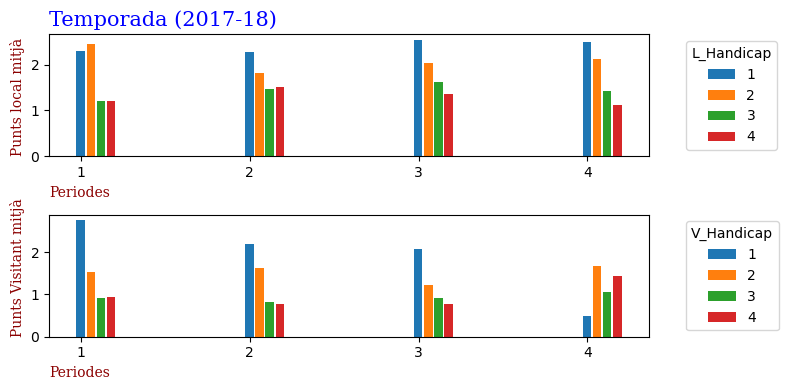

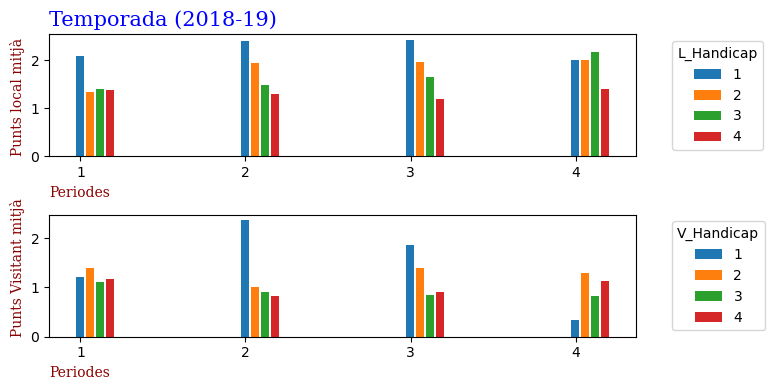

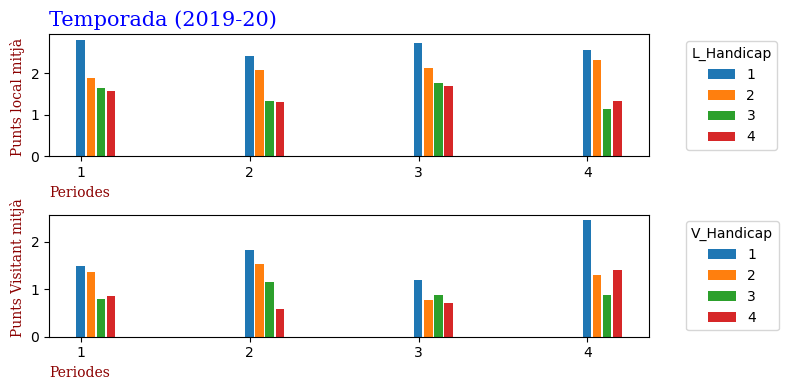

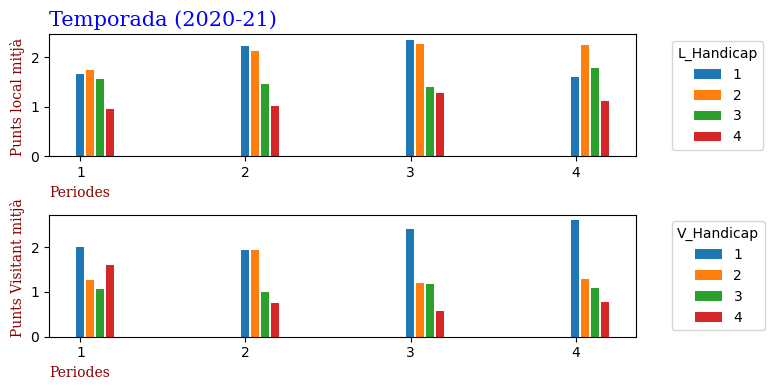

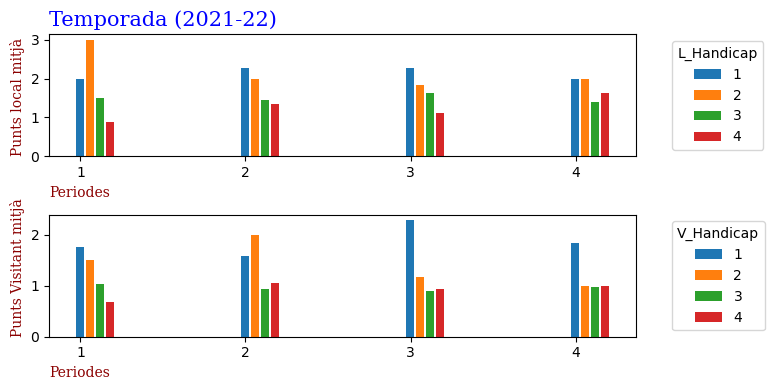

In [25]:
# Iterate in last 10 seasons without the actual
for temp in df_pfinal["Temp"].unique()[-11:-1]:
    grouped_lp = df_pfinal[df_pfinal["Temp"] == temp].groupby(["Per", "L_Han"])["LP"].mean().reset_index()
    grouped_vp = df_pfinal[df_pfinal["Temp"] == temp].groupby(["Per", "V_Han"])["VP"].mean().reset_index()
    
    plt.figure(figsize=(8, 4))
    
    # Plotting LP
    plt.subplot(2, 1, 1)
    for i, han in enumerate(grouped_lp["L_Han"].unique()):
        plt.bar(np.arange(len(df_pfinal["Per"].unique())) + (0.05 + 0.01) * i, grouped_lp[grouped_lp["L_Han"] == han]["LP"], width=0.05, label=han)
    
    font1 = {"family": "serif", "color": "blue", "size": 15}
    font2 = {"family": "serif", "color": "darkred", "size": 10}
    
    plt.title(f"Temporada ({temp})", fontdict=font1, loc="left")
    plt.xlabel("Periodes", fontdict=font2, loc="left")
    plt.ylabel("Punts local mitjà", fontdict=font2, loc="bottom")
    plt.legend(title="L_Handicap", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(np.arange(len(df_pfinal["Per"].unique())) + (0.05 + 0.01) * 0.05, df_pfinal['Per'].unique())
    
    # Plotting VP
    plt.subplot(2, 1, 2)
    for i, han in enumerate(grouped_vp["V_Han"].unique()):
        plt.bar(np.arange(len(df_pfinal["Per"].unique())) + (0.05 + 0.01) * i, grouped_vp[grouped_vp["V_Han"] == han]["VP"], width=0.05, label=han)
    
    plt.xlabel("Periodes", fontdict=font2, loc="left")
    plt.ylabel("Punts Visitant mitjà", fontdict=font2, loc="bottom")
    plt.legend(title="V_Handicap", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(np.arange(len(df_pfinal["Per"].unique())) + (0.05 + 0.01) * 0.05, df_pfinal['Per'].unique())
    
    # Adjusting subplots
    plt.tight_layout()
    
    # Show plot
    plt.show()

**Conclusions**

1. Hem pogut veure quines son les temporades amb més equips i més jornades. Curiosament,la temporada 86-87 és la que te més jornades però no més partits com hem pogut comprovar abans.

2. Hem classificat per veure els handicap dels equips i durant quants partits l'han mantingut. Com era d'esperar els únics equips amb Handicap 1 i amb moltes aparicions han estat Barcelona i Real Madrid, i amb una mica de participació de l'Atlètico de Madrid. Podria sorprendre que l'Athletic Bilbao que mai ha estat a segona divisió no estigui aquí però tenint en compte que rarament ha conseguit acabar en les primeres posicions no es tan extrany. Significa que hem fet una bona classificació d'aquesta columna.

3. He graficat l'agrupació del punt número dos per visualitzar-ho millor. Mateixes conclusions que el punt anterior, cuadra bastant amb l'esperata. 

4. Podem veure la repartació dels periodes és desigual. Em sembla interessant aquesta variable, ja que en la meva opinió els equips poden varia les seves dinàmiques al principi de temporada (posada en apunt) o final de temporada (objectius complerts o sense objectius ja). 

5. Volia veure com es compartaven els equips agrupats per handicap en cada un dels periodes per si la meva presuposició era infundada o no. Efectivament veiem que els equips es mantenen més estables en els periodes 2 i 3 mantenint quasi sempre el valor del Handicap. En el 1 i el 4 també però d'una forma més irregular, especialment en el 4 que es quan es jugeun els últims partits. També veiem com la mitjana de punts com a Local acostuma a ser millor que la de visitant i més estable. 

## PREPROCESSAT
   0. Eliminació de columnes així com divisió d'aquestes segons la seva categoria. 
   1. Distribució de les variables i veure tipus d'outliers
   2. Crear un pipeline de preprocessat de les columnes.

In [26]:
# Take a look columns name
df_pfinal.columns

Index(['Temp', 'Jor', 'Data', 'Per', 'Loc', 'Vis', 'LG', 'VG', '1-X-2', 'LP',
       'VP', 'L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL',
       'LD_10cL', 'V_Han', 'V10r', 'V10gf_cV', 'V10gc_cV', 'VV_10cV',
       'VE_10cV', 'VD_10cV'],
      dtype='object')

**CLASSIFICACIÓ DE COLUMNES**
   + Columnes que no utilitzarem -> Temp, Jor, Data, LP i VP (aquestes dues son directament consecuencia del target i no les podem obtenir sense saber el resultat, per tant no les podem utilitzar
   + Columnes TARGET -> LG i VG (per models de regressió) i "1-X-2" (models de classificació).
   + Dummies -> "Loc" i "Vis" -> Surtiren molts dummies :(.
   + Features númerics (la resta) -> 'L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL', 'LD_10cL', 
     'V_Han', 'V10r', 'V10gf_cV', 'V10gc_cV', 'VV_10cV', 'VE_10cV', 'VD_10cV'

Creerem un nou objecte amb un df per veure la distribució de les variables númeriques i target. Els dummies ja sabem que no tindren distribució gaussiana i els targets s'estudien per separat ja que és el que voldrem predir.

In [27]:
# Create a new df with only numeric variables to see each distribution and outliers
X_num = df_pfinal[['LG', 'VG', '1-X-2', 'Per', 'L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL', 'LD_10cL', 
                   'V_Han', 'V10r', 'V10gf_cV', 'V10gc_cV', 'VV_10cV', 'VE_10cV', 'VD_10cV']]
X_num

,LG,VG,1-X-2,Per,L_Han,L10r,L10gf_cL,L10gc_cL,LV_10cL,LE_10cL,LD_10cL,V_Han,V10r,V10gf_cV,V10gc_cV,VV_10cV,VE_10cV,VD_10cV
0,2,1,1,1,3,1.8,0.8,0.4,5,3,2,3,0.5,0.8,1.5,1,2,7
1,2,0,1,1,4,2.1,1.1,0.2,6,3,1,3,0.8,0.9,1.4,1,5,4
2,1,0,1,1,3,2.5,1.8,0.8,8,1,1,4,0.8,0.3,1.1,2,2,6
3,3,2,1,1,2,2.2,1.9,0.7,6,4,0,2,1.3,1.1,0.8,2,7,1
4,1,2,2,1,4,2.0,1.8,0.8,5,5,0,2,1.6,1.0,1.0,4,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16021,1,1,3,4,3,1.4,1.1,1.0,4,2,4,3,1.3,1.4,1.6,4,1,5
16022,1,0,1,4,3,1.5,1.1,0.8,4,3,3,3,1.3,1.2,1.3,3,4,3
16023,1,0,1,4,1,2.6,1.7,0.2,8,2,0,3,1.1,0.7,0.9,2,5,3
16024,2,1,1,4,4,1.4,1.2,1.3,4,2,4,4,0.4,0.4,1.9,1,1,8


In [28]:
# Create a function to see with a hipotesis  -> in this case if its Gaussian shape. 
# Show the Null hipotesis and the Alternative hipotesis
print("Nul Hipotesis (H0): The sample has a normal distribution (Probably Gaussian).")
print("Alternative Hipotesis (H1): The sample has NOT have a normal distribution (Probably NOT Gaussian).\n")

# Check if it is true the null hipotesis
for i in X_num.columns:
    shapiro_test = stats.shapiro(X_num[i])
    print("The variable", f" \033[1m{i}\033[0m", "has a \033[1mP-value\033[0m of", "\033[1m", shapiro_test.pvalue, "\033[0m")
    if shapiro_test.pvalue > 0.05:
        print("Nul hipotesis is accepted, The sample has a normal distribution \033[1m(Probably Gaussian)\033[0m.\n")
    else:
        print("Nul hipotesis is rejected, The sample has NOT a normal distribution \033[1m(Probably NOT Gaussian)\033[0m.\n")

Nul Hipotesis (H0): The sample has a normal distribution (Probably Gaussian).
Alternative Hipotesis (H1): The sample has NOT have a normal distribution (Probably NOT Gaussian).

The variable  LG has a P-value of  0.0 
Nul hipotesis is rejected, The sample has NOT a normal distribution (Probably NOT Gaussian).

The variable  VG has a P-value of  0.0 
Nul hipotesis is rejected, The sample has NOT a normal distribution (Probably NOT Gaussian).

The variable  1-X-2 has a P-value of  0.0 
Nul hipotesis is rejected, The sample has NOT a normal distribution (Probably NOT Gaussian).

The variable  Per has a P-value of  0.0 
Nul hipotesis is rejected, The sample has NOT a normal distribution (Probably NOT Gaussian).

The variable  L_Han has a P-value of  0.0 
Nul hipotesis is rejected, The sample has NOT a normal distribution (Probably NOT Gaussian).

The variable  L10r has a P-value of  6.114056238486747e-28 
Nul hipotesis is rejected, The sample has NOT a normal distribution (Probably NOT Gau

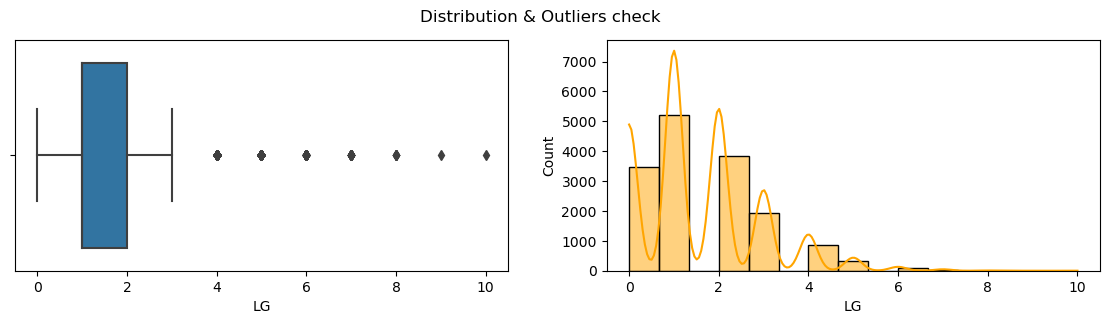

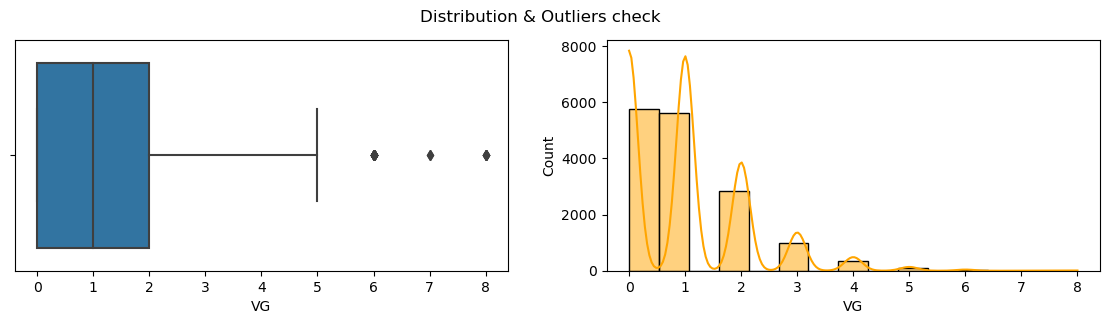

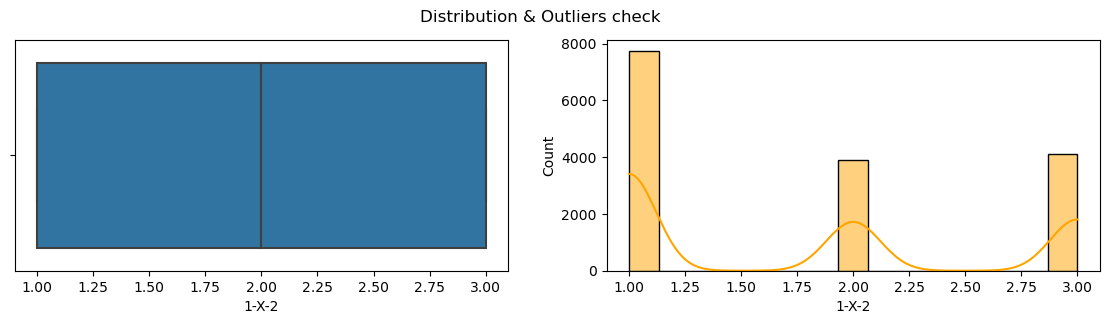

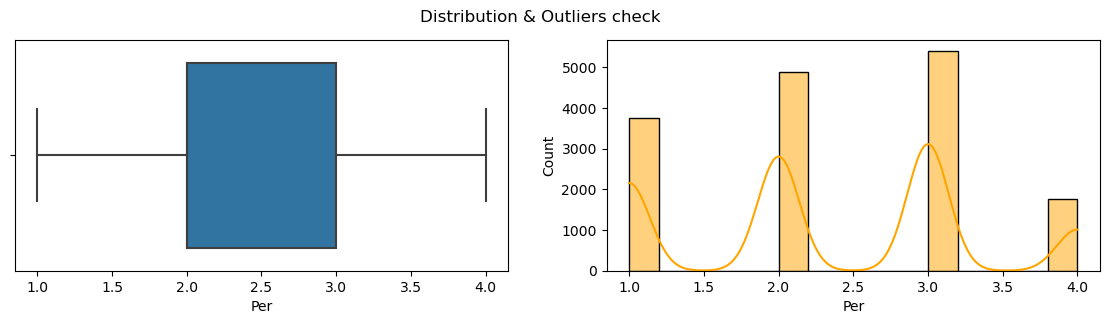

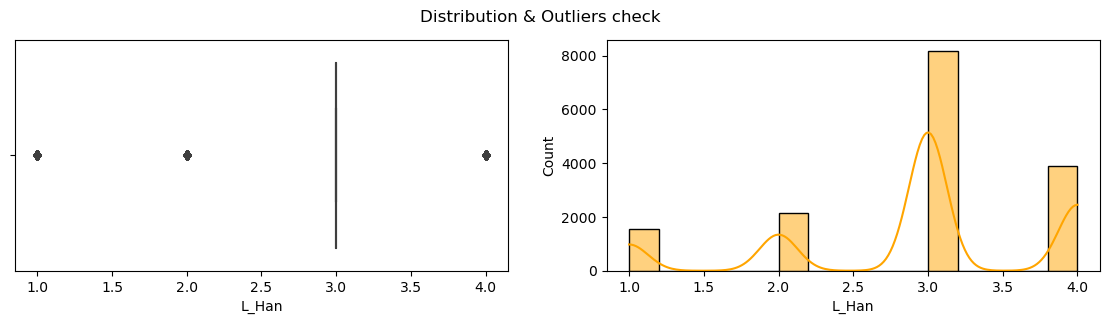

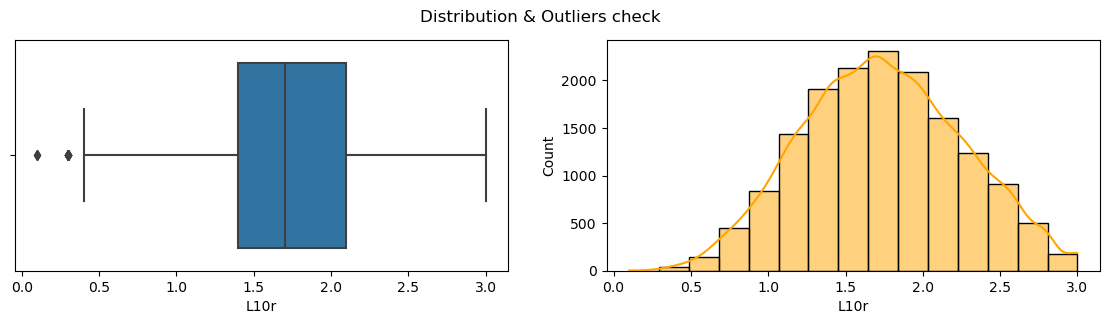

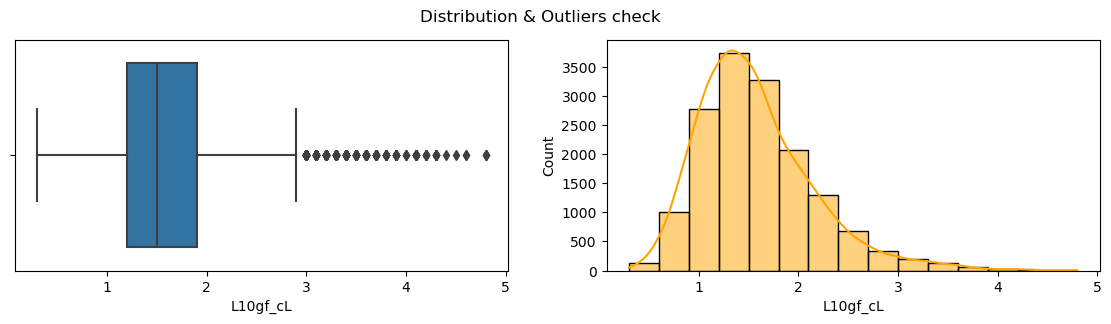

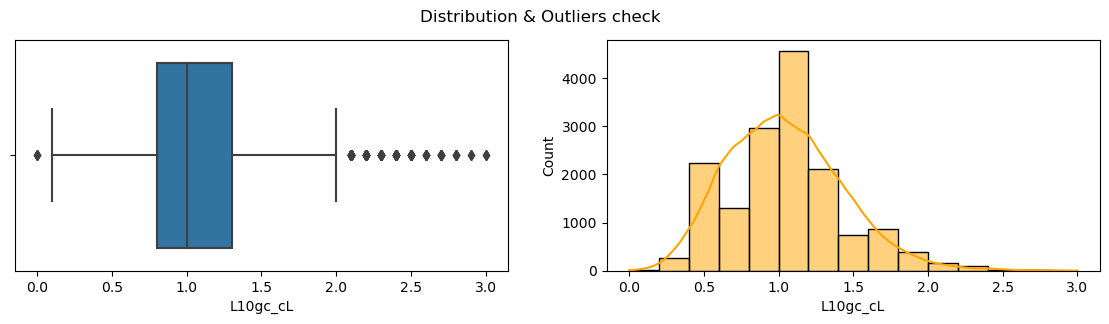

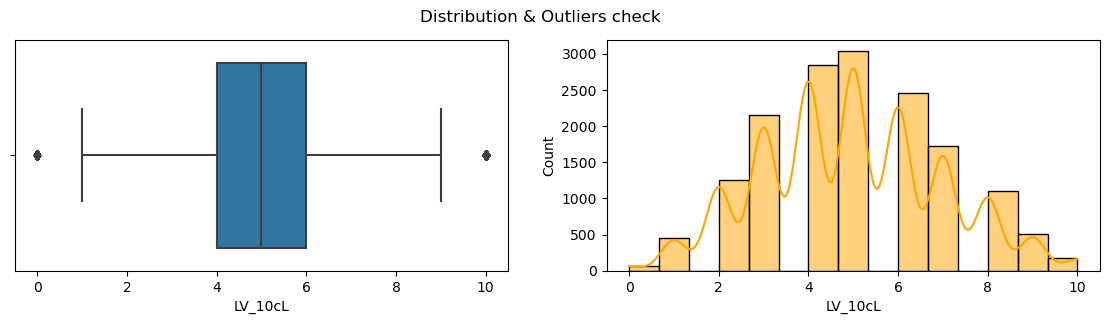

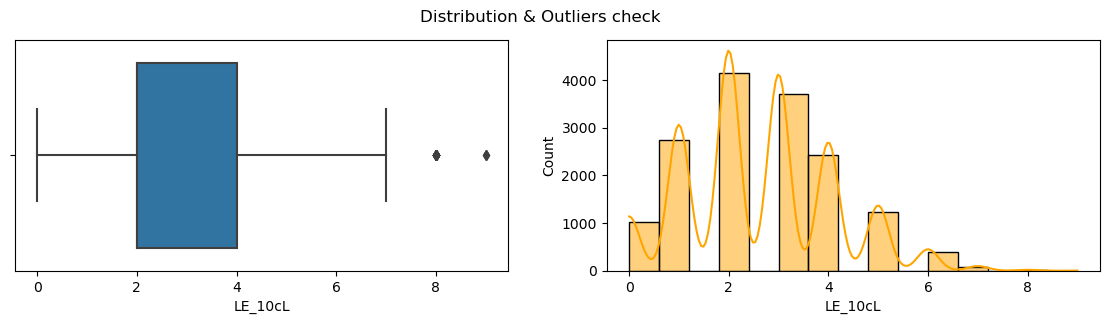

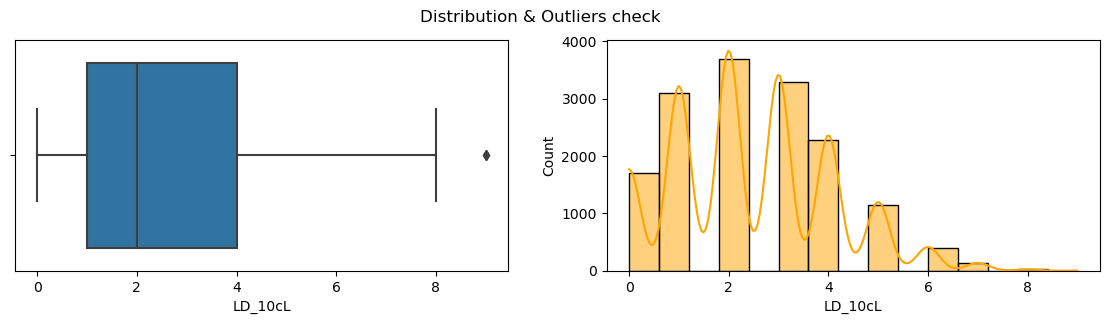

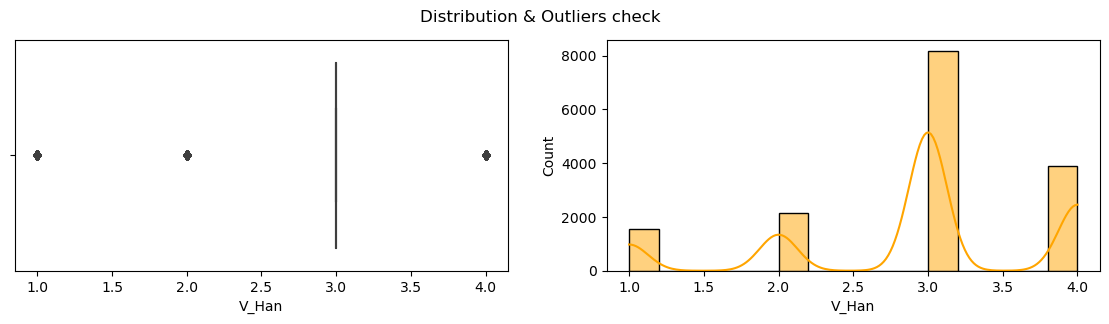

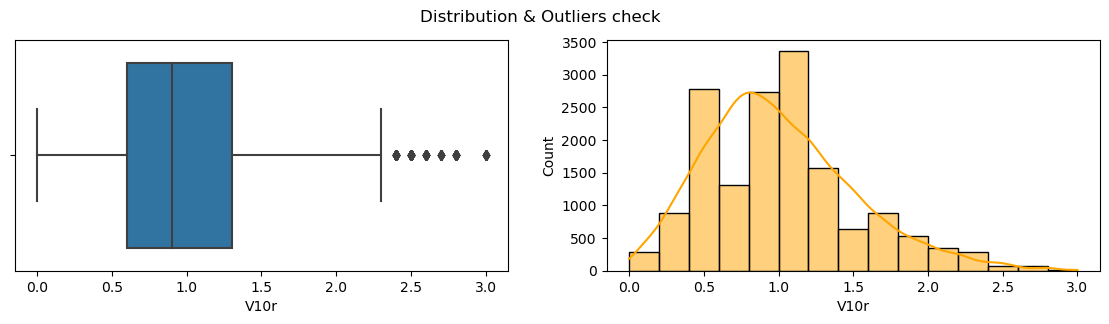

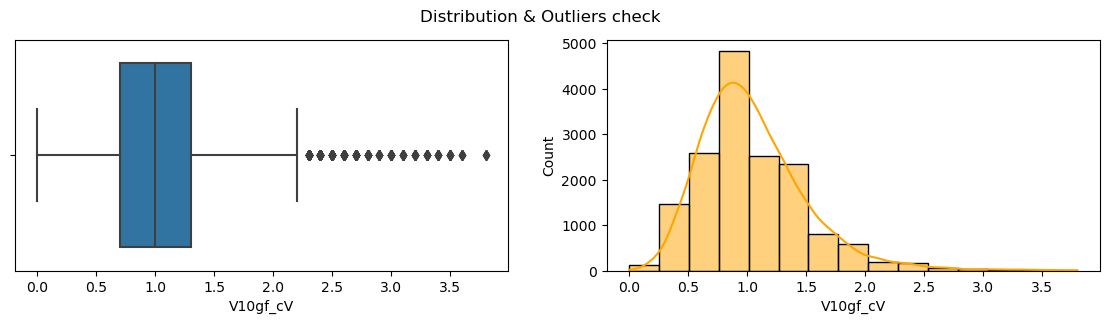

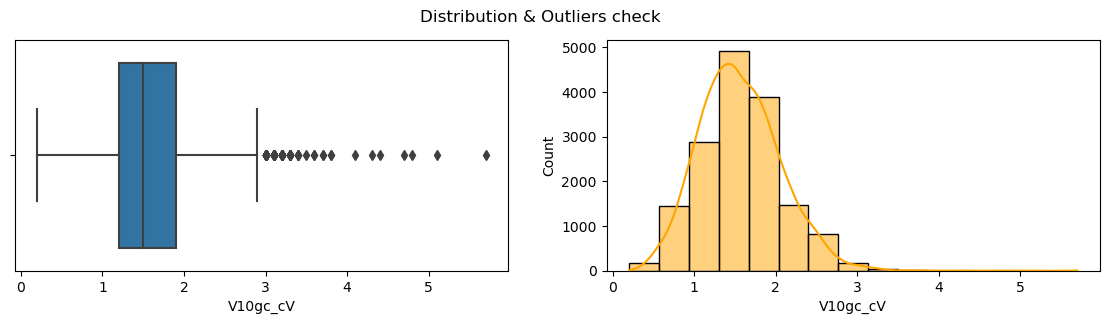

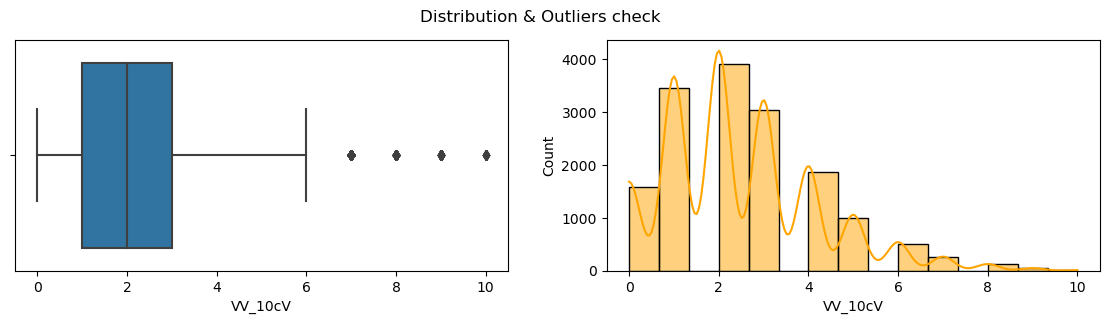

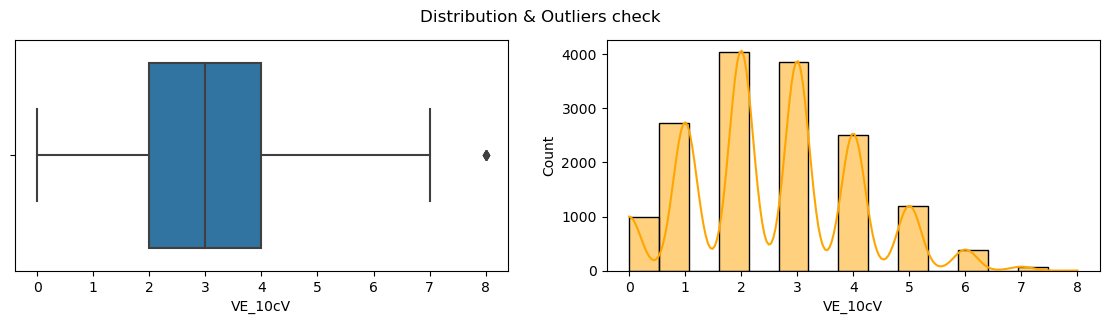

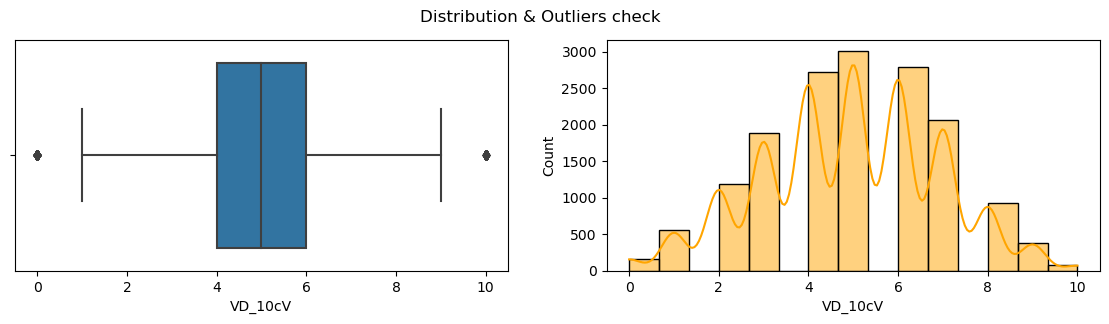

In [29]:
# Check the distribution with plots and if the features have outliers
# Create a iterative function for all the variables
for column in X_num:
    fig, axes = plt.subplots(1,2, figsize = (14,3))
    fig.suptitle('Distribution & Outliers check')
    sns.histplot(ax=axes[1], data=X_num, x=X_num[column], bins=15, color='orange', kde= True)
    sns.boxplot(ax=axes[0], x =X_num[column])

plt.show()

**TIPUS DE VARIABLES**

Hem vist que cap variable te distribució Gaussiana i totes contenen outliers. Per tant el preprocessat que farem serà el següent:

   + Variables categoriques (Loc i Vis) -> One Hot
   + Variables númeriques sin outlier (Per) -> MinMax
   + Variables NO gaussianes amb Outliers -> RobustSclaer

In [30]:
# Define type of preproceed
onehot = OneHotEncoder(drop="first", handle_unknown="ignore")
minmax = MinMaxScaler()
robusts = RobustScaler()

In [31]:
# define the data preparation for the columns
# Define the preproceed for each type of variable
preprocessor = ColumnTransformer(
                [("Categoric", onehot, ["Loc", "Vis"]), 
                 ("MinMax", minmax, ["Per"]), 
                 ("Robust", robusts, ['L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL', 'LD_10cL', 'V_Han',
                                      'V10r', 'V10gf_cV', 'V10gc_cV', 'VV_10cV', 'VE_10cV', 'VD_10cV'])], remainder = "drop")

In [32]:
# Features
X = df_pfinal[['Per', 'Loc', 'Vis', 'L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL', 'LD_10cL', 'V_Han', 'V10r', 
               'V10gf_cV', 'V10gc_cV', 'VV_10cV', 'VE_10cV', 'VD_10cV']]

# Diferent targets
yl = df_pfinal["LG"]
yv = df_pfinal["VG"]
yc = df_pfinal["1-X-2"]

print("Forma Features:", X.shape)
print("Forma Target Gols Locals:", yl.shape)
print("Forma Target Gols Visitants:", yv.shape)
print("Forma Target resultat:", yc.shape)

Forma Features: (15766, 17)
Forma Target Gols Locals: (15766,)
Forma Target Gols Visitants: (15766,)
Forma Target resultat: (15766,)


## CREACIÓ MODELS

> 1. Regressió
> 2. Classificació

In [33]:
# Declare models
LR_l = LinearRegression()
KNR_l = KNeighborsRegressor()
SVM_l = SVR()

In [34]:
# Define data and modeling pipeline
LR_l_pipeline = Pipeline([('prep',preprocessor), ('LR_l', LR_l)])
KNR_l_pipeline = Pipeline([('prep',preprocessor), ('KNR_l', KNR_l)])
SVM_l_pipeline = Pipeline([('prep',preprocessor), ('SVM_l', SVM_l)])


In [35]:
# Split data into train i test
X_train, X_test, yl_train, yl_test = train_test_split(X, yl, test_size=0.3, random_state=5)

In [36]:
# Call pipeline model and show what it does
LR_l_pipeline

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('Categoric',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Loc', 'Vis']),
                                                 ('MinMax', MinMaxScaler(),
                                                  ['Per']),
                                                 ('Robust', RobustScaler(),
                                                  ['L_Han', 'L10r', 'L10gf_cL',
                                                   'L10gc_cL', 'LV_10cL',
                                                   'LE_10cL', 'LD_10cL',
                                                   'V_Han', 'V10r', 'V10gf_cV',
                                                   'V10gc_cV', 'VV_10cV',
                                                   'VE_10cV', 'VD_10cV'])])),
      

In [37]:
# Fit one model to look if it fits well
LR_l_pipeline.fit(X_train, yl_train)
print('R2 score: {0:.2f}'.format(LR_l_pipeline.score(X_test, yl_test)))

R2 score: 0.11


In [38]:
# Round up predicitons of X_test
from sklearn.metrics import r2_score
yl_pred = LR_l_pipeline.predict(X_test)
yl_pred_lr = np.round(LR_l_pipeline.predict(X_test), 0)
print("Prediccions reals:", LR_l_pipeline.predict(X_test), "\nPrediccions arrodonides:",yl_pred_lr)

Prediccions reals: [1.6000067  2.6832324  1.45144891 ... 1.5145511  1.23091216 1.43376134] 
Prediccions arrodonides: [2. 3. 1. ... 2. 1. 1.]


In [39]:
print("MAE para lr: {0:.2f}".format(mean_absolute_error(yl_test, yl_pred_lr)), 
     "R2 para lr: {0:.2f}".format(r2_score(yl_test, yl_pred)))

MAE para lr: 0.94 R2 para lr: 0.11


In [40]:
# Create a df with all models pipelines
regressio = [("LR_l", LR_l_pipeline), ("KNR_l", KNR_l_pipeline), ("SVM_l", SVM_l_pipeline)]

In [41]:
# Create a bucle to show each model how it works
for name, model in regressio:
    cv = cross_validate(model, X, yl, cv=5, scoring=["neg_mean_absolute_error", "r2"])
    mae =-cv["test_neg_mean_absolute_error"]
    r2 = cv["test_r2"]
    print(name)
    print(f"Mean Absolute Error:{mae.mean():.3f} +/- {mae.std():.3f}\n", f"R2 accuracy:{r2.mean():.3f} +/- {r2.std():.3f}")
    print()

LR_l
Mean Absolute Error:0.981 +/- 0.022
 R2 accuracy:0.096 +/- 0.037

KNR_l
Mean Absolute Error:1.058 +/- 0.017
 R2 accuracy:-0.082 +/- 0.074

SVM_l
Mean Absolute Error:0.978 +/- 0.019
 R2 accuracy:0.051 +/- 0.047



In [42]:
# Create a bucle to calculate same metrics for each model with rounded yl_pred
regressio = [("LR_l", LR_l_pipeline), ("KNR_l", KNR_l_pipeline), ("SVM_l", SVM_l_pipeline)]

for name, model in regressio:
    model.fit(X_train, yl_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(yl_test, y_pred)
    r2 = r2_score(yl_test, y_pred)
    print("MAE para {}: {:.2f}".format(name, mae))
    print("R2 para {}: {:.2f}".format(name, r2))
    print()
    

MAE para LR_l: 0.96
R2 para LR_l: 0.11

MAE para KNR_l: 1.03
R2 para KNR_l: -0.05

MAE para SVM_l: 0.96
R2 para SVM_l: 0.06



In [43]:
# LR hyperparameters
lr_params = {"LR_l__copy_X": [True, False],
            "LR_l__fit_intercept": [True, False],
            "LR_l__n_jobs": [-1, None, 1],
            "LR_l__positive": [True, False]}

# KNR hyperparameters
knr_params = {"KNR_l__n_neighbors": [int(x) for x in np.linspace(start = 1, stop = 30, num = 3)],
              "KNR_l__weights": ["uniform", "distance"],
              "KNR_l__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              "KNR_l__leaf_size": [int(x) for x in np.linspace(start = 5, stop = 50, num = 5)],
              "KNR_l__p": [int(x) for x in np.linspace(start = 1, stop = 4, num = 1)]}

# SVM hyperparameters
svm_params = {"SVM_l__C": [0.1, 1, 2, 10], 
             "SVM_l__coef0": [0.0, 0.5, 1],  
             "SVM_l__degree": [3, 5, 8], 
             "SVM_l__kernel": ['rbf', 'linear', 'rbf', 'sigmoid']}

In [44]:
# Declare objects
regression = [("LR_l", LR_l_pipeline), ("KNR_l", KNR_l_pipeline), ("SVM_l", SVM_l_pipeline)]
hyper_params = [("LR_l", lr_params), ("KNR_l", knr_params), ("SVM_l", svm_params)]

for name, model in regression:
    params = next(hp for hp in hyper_params if hp[0] == name)[1]
    
    grids = RandomizedSearchCV(model, params, cv=5, scoring=['r2', 'neg_mean_absolute_error'], refit='neg_mean_absolute_error', random_state=5)
    grids.fit(X, yl)
    y_pred = grids.predict(X)
    r2 = r2_score(yl, y_pred)
    
    print(name)
    print(f"The best result for R2 is {r2:.3f}")
    print(f"The best hyperparameters for {name} are: {grids.best_params_}\n")

LR_l
The best result for R2 is 0.124
The best hyperparameters for LR_l are: {'LR_l__positive': False, 'LR_l__n_jobs': -1, 'LR_l__fit_intercept': False, 'LR_l__copy_X': False}

KNR_l
The best result for R2 is 0.145
The best hyperparameters for KNR_l are: {'KNR_l__weights': 'uniform', 'KNR_l__p': 1, 'KNR_l__n_neighbors': 30, 'KNR_l__leaf_size': 16, 'KNR_l__algorithm': 'auto'}

SVM_l
The best result for R2 is 0.107
The best hyperparameters for SVM_l are: {'SVM_l__kernel': 'rbf', 'SVM_l__degree': 3, 'SVM_l__coef0': 0.5, 'SVM_l__C': 0.1}



In [45]:
# Add best parameters to models
LR_l = LinearRegression(positive = False, n_jobs = -1, fit_intercept = False, copy_X = False)
KNR_l = KNeighborsRegressor(weights = 'uniform', p = 1, n_neighbors = 30, leaf_size = 16, algorithm = 'auto')
SVM_l = SVR(kernel = 'rbf', degree= 3, coef0 = 0.5, C = 0.1)

In [46]:
# Define data and modeling pipeline
LR_l_pipeline = Pipeline([('prep',preprocessor), ('LR_l', LR_l)])
KNR_l_pipeline = Pipeline([('prep',preprocessor), ('KNR_l', KNR_l)])
SVM_l_pipeline = Pipeline([('prep',preprocessor), ('SVM_l', SVM_l)])

In [47]:
# Show metrics for each model with best parameters
regressio = [("LR_l", LR_l_pipeline), ("KNR_l", KNR_l_pipeline), ("SVM_l", SVM_l_pipeline)]

for name, model in regressio:
    model.fit(X, yl)
    y_pred = model.predict(X)
    mae = mean_absolute_error(yl, y_pred)
    r2 = r2_score(yl, y_pred)


    print("MAE para {}: {:.3f}".format(name, mae))
    print("R2 para {}: {:.3f}".format(name, r2))
    print()

MAE para LR_l: 0.967
R2 para LR_l: 0.124

MAE para KNR_l: 0.953
R2 para KNR_l: 0.145

MAE para SVM_l: 0.926
R2 para SVM_l: 0.107



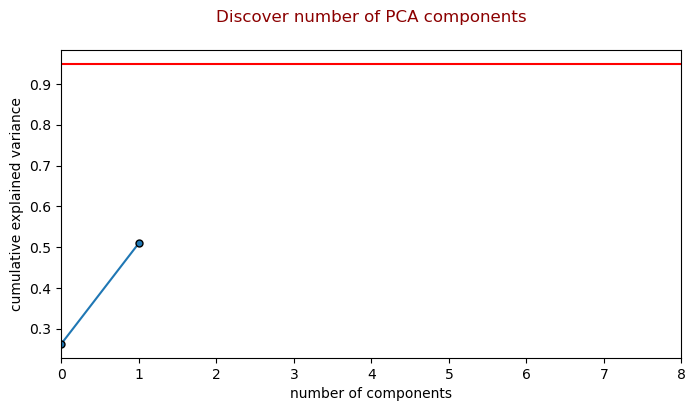

In [48]:
# import libraries to apply PCA method
from sklearn.decomposition import PCA, TruncatedSVD

X_preprocessed = preprocessor.fit_transform(X)

# Create a plot to see how many PC will be optimal to use
svd = TruncatedSVD().fit(X_preprocessed)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker="o", markersize=5, markeredgecolor='black')
plt.axhline(0.95, color="r", linestyle="-")
plt.xlim([0, 8])
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.title("Discover number of PCA components", fontsize=12, pad=20, color='darkred')
plt.show()


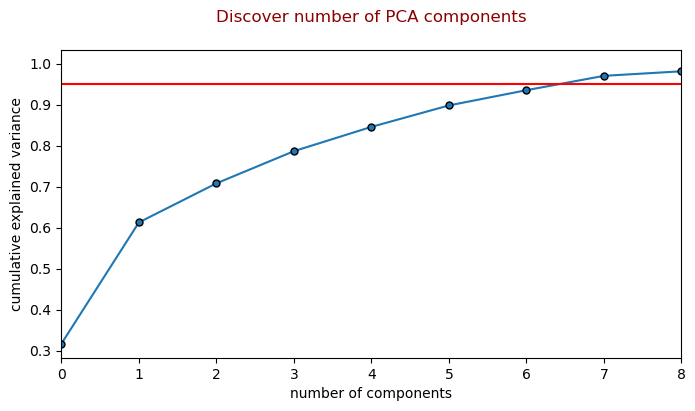

In [49]:
# Create variable without dummie
Xpca = df_pfinal[['Per', 'L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL', 'LD_10cL', 'V_Han', 'V10r', 
               'V10gf_cV', 'V10gc_cV', 'VV_10cV', 'VE_10cV', 'VD_10cV']]

# Preprocessor without dummies
preprocessor2 = ColumnTransformer(
                [("MinMax", minmax, ["Per"]), 
                 ("Robust", robusts, ['L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL', 'LD_10cL', 'V_Han',
                                      'V10r', 'V10gf_cV', 'V10gc_cV', 'VV_10cV', 'VE_10cV', 'VD_10cV'])], remainder = "drop")

X_preprocessed = preprocessor2.fit_transform(Xpca)

# Create a plot to see how many PC will be optimal to use
pca = PCA().fit(X_preprocessed)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o", markersize=5, markeredgecolor='black')
plt.axhline(0.95, color="r", linestyle="-")
plt.xlim([0, 8])
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.title("Discover number of PCA components", fontsize=12, pad=20, color='darkred')
plt.show()


In [50]:
# Define data and modeling pipeline
LR_l_pca_pipeline = Pipeline([('prep',preprocessor2), ('pca', PCA(n_components = 0.99)), ('LR_l', LR_l)])
KNR_l_pca_pipeline = Pipeline([('prep',preprocessor2), ('pca', PCA(n_components = 0.99)), ('KNR_l', KNR_l)])
SVM_l_pca_pipeline = Pipeline([('prep',preprocessor2), ('pca', PCA(n_components = 0.99)), ('SVM_l', SVM_l)])

# Show best R2 for each model with PCA 
regressio_pca = [("LR_l", LR_l_pca_pipeline), ("KNR_l", KNR_l_pca_pipeline), ("SVM_l", SVM_l_pca_pipeline)]
for name, model in regressio_pca:
    score = cross_val_score(model, X, yl, cv=5, scoring='r2')
    print("R2 para {}: {:.2f}".format(name, score.mean()))

R2 para LR_l: -1.32
R2 para KNR_l: 0.08
R2 para SVM_l: 0.06


_He intentat aplicar PCA pero em deia que la dada era massa dispera i que provés amb SVD. Però com podem veure en el gràfic només pot recopilar el 0.5 de la dada. He tornat a mirar el PCA sense els dummies i ara si que m'ho ha pogut calcular el número de components. De tota manera ens estem deixant molta informació si no utlitzem els dummies_

**Vist totes les opcions la millor es KNeighborsRegression() sense PCA** amb un R2 de 0.145 y un MAE de 0.95. Son valors bastant dolents, tant en la R2 com en el MAE tenint en compte que el rang de gols va de 0 a 10 i la mitja d'error és de quasi un gol. 

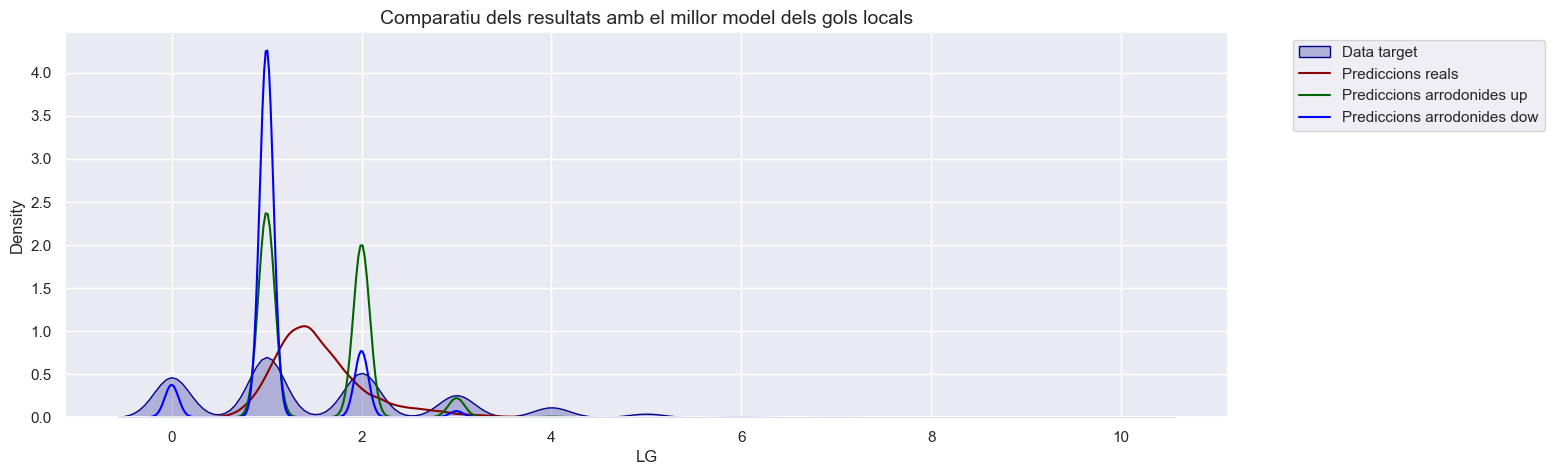

In [51]:
# plot predictions with differents options
sns.set(rc={"figure.figsize": (15, 5)})
sns.kdeplot(yl, label='Data target', color='Darkblue', fill=True)
sns.kdeplot(KNR_l_pipeline.predict(X), label='Prediccions reals', color='Darkred', fill=False)
sns.kdeplot(np.round(KNR_l_pipeline.predict(X), 0), label='Prediccions arrodonides up', color='Darkgreen', fill=False)
sns.kdeplot(np.floor(KNR_l_pipeline.predict(X)), label='Prediccions arrodonides dow', color='blue', fill=False)

plt.title("Comparatiu dels resultats amb el millor model dels gols locals", fontsize = 14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Gols visitants

In [52]:
# Declare models
LR_v = LinearRegression()
KNR_v = KNeighborsRegressor()
SVM_v = SVR()

In [53]:
# Define data and modeling pipeline
LR_v_pipeline = Pipeline([('prep',preprocessor), ('LR_v', LR_v)])
KNR_v_pipeline = Pipeline([('prep',preprocessor), ('KNR_v', KNR_v)])
SVM_v_pipeline = Pipeline([('prep',preprocessor), ('SVM_v', SVM_v)])

In [54]:
# Split data into train i test
X_train, X_test, yv_train, yv_test = train_test_split(X, yv, test_size=0.3, random_state=5)

In [55]:
# Create a bucle to calculate same metrics for each model with rounded yl_pred
regressio = [("LR_v", LR_v_pipeline), ("KNR_v", KNR_v_pipeline), ("SVM_v", SVM_v_pipeline)]

for name, model in regressio:
    model.fit(X_train, yv_train)
    y_pred = model.predict(X_test)
    y_predm = np.round(model.predict(X_test), decimals=0)
    mae = mean_absolute_error(yv_test, y_pred)
    r2 = r2_score(yv_test, y_pred)
    print("MAE para {}: {:.2f}".format(name, mae))
    print("R2 para {}: {:.2f}".format(name, r2))
    print()

MAE para LR_v: 0.80
R2 para LR_v: 0.07

MAE para KNR_v: 0.87
R2 para KNR_v: -0.09

MAE para SVM_v: 0.81
R2 para SVM_v: 0.02



In [56]:
# LR hyperparameters
lr_params = {"LR_v__copy_X": [True, False],
            "LR_v__fit_intercept": [True, False],
            "LR_v__n_jobs": [-1, None, 1],
            "LR_v__positive": [True, False]}

# KNR hyperparameters
knr_params = {"KNR_v__n_neighbors": [int(x) for x in np.linspace(start = 1, stop = 30, num = 3)],
              "KNR_v__weights": ["uniform", "distance"],
              "KNR_v__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              "KNR_v__leaf_size": [int(x) for x in np.linspace(start = 5, stop = 50, num = 5)],
              "KNR_v__p": [int(x) for x in np.linspace(start = 1, stop = 4, num = 1)]}

# SVM hyperparameters
svm_params = {"SVM_v__C": [0.1, 1, 2, 10], 
             "SVM_v__coef0": [0.0, 0.5, 1],  
             "SVM_v__degree": [3, 5, 8], 
             "SVM_v__kernel": ['rbf', 'linear', 'rbf', 'sigmoid']}

In [57]:
# Declare objects
regressio = [("LR_v", LR_v_pipeline), ("KNR_v", KNR_v_pipeline), ("SVM_v", SVM_v_pipeline)]
hyper_params = [("LR_v", lr_params), ("KNR_v", knr_params), ("SVM_v", svm_params)]

for name, model in regressio:
    params = next(hp for hp in hyper_params if hp[0] == name)[1]
    
    grids = RandomizedSearchCV(model, params, cv=5, scoring=['r2', 'neg_mean_absolute_error'], refit='neg_mean_absolute_error', random_state=5)
    grids.fit(X, yv)
    y_pred = grids.predict(X)
    r2 = r2_score(yv, y_pred)
    
    print(name)
    print(f"The best result for R2 is {r2:.3f}")
    print(f"The best hyperparameters for {name} are: {grids.best_params_}\n")

LR_v
The best result for R2 is 0.084
The best hyperparameters for LR_v are: {'LR_v__positive': False, 'LR_v__n_jobs': -1, 'LR_v__fit_intercept': False, 'LR_v__copy_X': False}

KNR_v
The best result for R2 is 0.110
The best hyperparameters for KNR_v are: {'KNR_v__weights': 'uniform', 'KNR_v__p': 1, 'KNR_v__n_neighbors': 30, 'KNR_v__leaf_size': 16, 'KNR_v__algorithm': 'auto'}

SVM_v
The best result for R2 is 0.085
The best hyperparameters for SVM_v are: {'SVM_v__kernel': 'rbf', 'SVM_v__degree': 3, 'SVM_v__coef0': 0.5, 'SVM_v__C': 0.1}



In [58]:
# Define models with best parameters
LR_v = LinearRegression(positive = False, n_jobs = -1, fit_intercept = False, copy_X = False)
KNR_v = KNeighborsRegressor(weights = 'uniform', p = 1, n_neighbors = 30, leaf_size = 16, algorithm = 'auto')
SVM_v = SVR(kernel = 'rbf', degree= 3, coef0 = 0.5, C = 0.1)

In [59]:
# Define data and modeling pipeline
LR_v_pipeline = Pipeline([('prep',preprocessor), ('LR_v', LR_v)])
KNR_v_pipeline = Pipeline([('prep',preprocessor), ('KNR_v', KNR_v)])
SVM_v_pipeline = Pipeline([('prep',preprocessor), ('SVM_v', SVM_v)])

In [60]:
# Apply best parameters to each model
regressio = [("LR_v", LR_v_pipeline), ("KNR_v", KNR_v_pipeline), ("SVM_v", SVM_v_pipeline)]

for name, model in regressio:
    model.fit(X, yv)
    y_pred = model.predict(X)
    mae = mean_absolute_error(yv, y_pred)
    r2 = r2_score(yv, y_pred)


    print("MAE para {}: {:.3f}".format(name, mae))
    print("R2 para {}: {:.3f}".format(name, r2))
    print()

MAE para LR_v: 0.801
R2 para LR_v: 0.084

MAE para KNR_v: 0.790
R2 para KNR_v: 0.110

MAE para SVM_v: 0.773
R2 para SVM_v: 0.085



**El millor model pels gols visitants també és el KNR i els resultats son semblants. Una MAE millor, 0.79 (segurament perquè els gols visitants acostument a ser inferiors) i una R2 pitjor.**

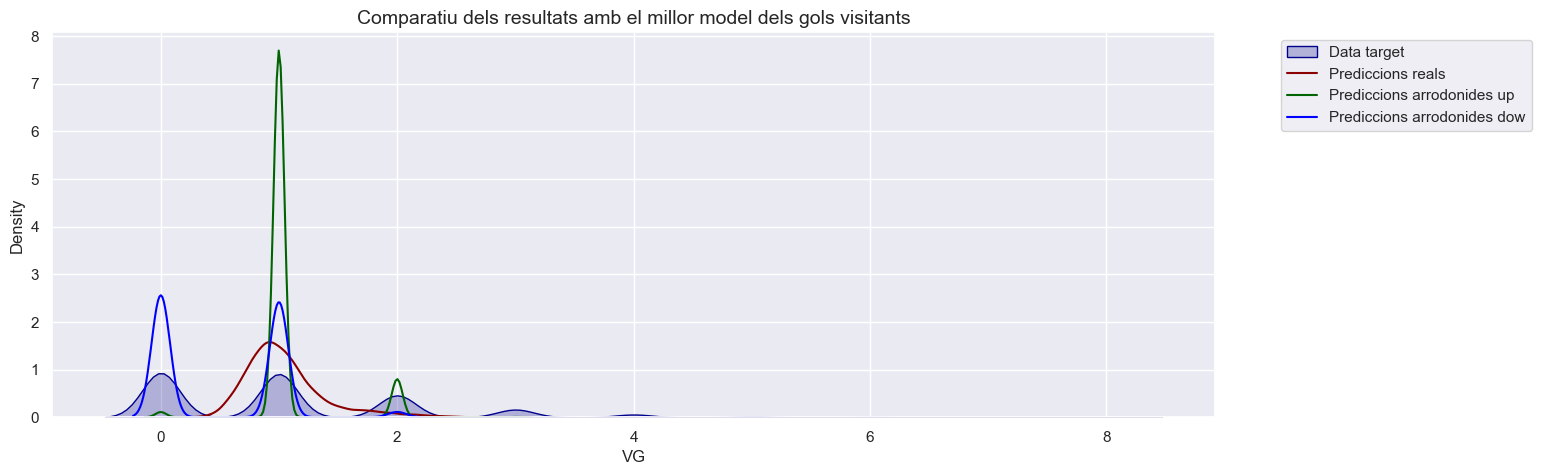

In [61]:
# plot predictions with differents options
sns.set(rc={"figure.figsize": (15, 5)})
sns.kdeplot(yv, label='Data target', color='Darkblue', fill=True)
sns.kdeplot(KNR_v_pipeline.predict(X), label='Prediccions reals', color='Darkred', fill=False)
sns.kdeplot(np.round(KNR_v_pipeline.predict(X), 0), label='Prediccions arrodonides up', color='Darkgreen', fill=False)
sns.kdeplot(np.floor(KNR_v_pipeline.predict(X)), label='Prediccions arrodonides dow', color='blue', fill=False)

plt.title("Comparatiu dels resultats amb el millor model dels gols visitants", fontsize = 14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## PREDICCIONS

In [62]:
# Import two dataset create
prediccions34 = pd.read_csv("jornada34.csv", sep = ",", encoding="utf-8-sig")

# Unify name of columns
prediccions34.columns = ["Temp", "Jor", "Data", "Loc", "Vis", "LG", "VG", "1-X-2", "LP", "VP", "L10gf_cL", "V10gf_cV", "L10gc_cL", "V10gc_cV", "L10r", "V10r", "LV_10cL", "LE_10cL", "LD_10cL", "VV_10cV", "VE_10cV", "VD_10cV", "Per", "L_Han", "V_Han"]

# Show principal dataset
prediccions34

,Temp,Jor,Data,Loc,Vis,LG,VG,1-X-2,LP,VP,...,V10r,LV_10cL,LE_10cL,LD_10cL,VV_10cV,VE_10cV,VD_10cV,Per,L_Han,V_Han
0,2022-23,34,2023-05-14,Betis,Rayo Vallecano,-1,-1,X,1,1,...,1.2,3.0,4.0,3.0,3.0,3.0,4.0,4,3,4
1,2022-23,34,2023-05-14,Celta de Vigo,Valencia,-1,-1,X,1,1,...,0.3,4.0,3.0,3.0,1.0,0.0,9.0,4,3,3
2,2022-23,34,2023-05-14,Villarreal,Athletic Club,-1,-1,X,1,1,...,1.5,6.0,1.0,3.0,4.0,3.0,3.0,4,3,3
3,2022-23,34,2023-05-14,Elche,Atlético de Madrid,-1,-1,X,1,1,...,1.7,2.0,2.0,6.0,5.0,2.0,3.0,4,4,1
4,2022-23,34,2023-05-14,Espanyol,Barcelona,-1,-1,X,1,1,...,2.2,3.0,3.0,4.0,7.0,1.0,2.0,4,3,1
5,2022-23,34,2023-05-14,Real Madrid,Getafe,-1,-1,X,1,1,...,0.3,7.0,2.0,1.0,0.0,3.0,7.0,4,1,3
6,2022-23,34,2023-05-14,Mallorca,Cádiz,-1,-1,X,1,1,...,0.9,6.0,3.0,1.0,2.0,3.0,5.0,4,3,4
7,2022-23,34,2023-05-14,Valladolid,Sevilla,-1,-1,X,1,1,...,1.2,4.0,2.0,4.0,3.0,3.0,4.0,4,4,2
8,2022-23,34,2023-05-14,Osasuna,Almería,-1,-1,X,1,1,...,0.6,4.0,1.0,5.0,1.0,3.0,6.0,4,3,4
9,2022-23,34,2023-05-14,Real Sociedad,Girona,-1,-1,X,1,1,...,1.2,6.0,3.0,1.0,3.0,3.0,4.0,4,3,4


In [63]:
# Define features of dataset for prediction
predX = prediccions34[['Per', 'Loc', 'Vis', 'L_Han', 'L10r', 'L10gf_cL', 'L10gc_cL', 'LV_10cL', 'LE_10cL', 'LD_10cL', 'V_Han', 'V10r', 
               'V10gf_cV', 'V10gc_cV', 'VV_10cV', 'VE_10cV', 'VD_10cV']]

# Predict local goals
yl_pred_34d = KNR_l_pipeline.predict(predX)
yl_pred_34r = np.round(KNR_l_pipeline.predict(predX), 0)
yl_pred_34f = np.floor(KNR_l_pipeline.predict(predX))

print("\033[1mGols Locals\033[0m")
print("Prediccions reals:", ", ".join(str(x) for x in yl_pred_34d))
print("Prediccions arrodonides:", ", ".join(str(x) for x in yl_pred_34r))
print("Prediccions arrodonides down:", ", ".join(str(x) for x in yl_pred_34f))

Gols Locals
Prediccions reals: 1.6333333333333333, 1.6333333333333333, 1.8, 0.8333333333333334, 1.0, 2.4, 1.7, 1.1666666666666667, 1.5666666666666667, 1.6333333333333333
Prediccions arrodonides: 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0
Prediccions arrodonides down: 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0


In [64]:
# Predict visitant goals
yv_pred_34d = KNR_v_pipeline.predict(predX)
yv_pred_34r = np.round(KNR_v_pipeline.predict(predX), 0)
yv_pred_34f = np.floor(KNR_v_pipeline.predict(predX))

print("\033[1mGols visitants\033[0m")
print("Prediccions reales:", yv_pred_34d)
print("Prediccions arrodonides up:", yv_pred_34r)
print("Prediccions arrodonides down:", yv_pred_34f)

Gols visitants
Prediccions reales: [1.1        1.26666667 0.93333333 1.8        1.9        0.96666667
 0.73333333 0.83333333 0.8        1.1       ]
Prediccions arrodonides up: [1. 1. 1. 2. 2. 1. 1. 1. 1. 1.]
Prediccions arrodonides down: [1. 1. 0. 1. 1. 0. 0. 0. 0. 1.]


In [65]:
# Create a df with the predictions
pred_jornada34 = prediccions34[["Temp", "Jor", "Data", "Loc", "Vis", "LG", "VG"]]
pred_jornada34 = pred_jornada34.assign(LPredd=yl_pred_34d, LPredr=yl_pred_34r, LPredf=yl_pred_34f, VPredd=yv_pred_34d, VPredr=yv_pred_34r, VPredf=yv_pred_34f)
pred_jornada34

,Temp,Jor,Data,Loc,Vis,LG,VG,LPredd,LPredr,LPredf,VPredd,VPredr,VPredf
0,2022-23,34,2023-05-14,Betis,Rayo Vallecano,-1,-1,1.633333,2.0,1.0,1.100000,1.0,1.0
1,2022-23,34,2023-05-14,Celta de Vigo,Valencia,-1,-1,1.633333,2.0,1.0,1.266667,1.0,1.0
2,2022-23,34,2023-05-14,Villarreal,Athletic Club,-1,-1,1.800000,2.0,1.0,0.933333,1.0,0.0
3,2022-23,34,2023-05-14,Elche,Atlético de Madrid,-1,-1,0.833333,1.0,0.0,1.800000,2.0,1.0
4,2022-23,34,2023-05-14,Espanyol,Barcelona,-1,-1,1.000000,1.0,1.0,1.900000,2.0,1.0
5,2022-23,34,2023-05-14,Real Madrid,Getafe,-1,-1,2.400000,2.0,2.0,0.966667,1.0,0.0
6,2022-23,34,2023-05-14,Mallorca,Cádiz,-1,-1,1.700000,2.0,1.0,0.733333,1.0,0.0
7,2022-23,34,2023-05-14,Valladolid,Sevilla,-1,-1,1.166667,1.0,1.0,0.833333,1.0,0.0
8,2022-23,34,2023-05-14,Osasuna,Almería,-1,-1,1.566667,2.0,1.0,0.800000,1.0,0.0
9,2022-23,34,2023-05-14,Real Sociedad,Girona,-1,-1,1.633333,2.0,1.0,1.100000,1.0,1.0
